* 投球数が多い5投手の遷移確立と出力確率を数え上げる


In [1]:
import pandas as pd
df = pd.read_csv('df_clean_zone_cluster.csv')

In [2]:
import pandas as pd
import numpy as np

# -------------------------------------------------------------------
# 1) データ読み込み
# -------------------------------------------------------------------
df = pd.read_csv('df_clean_zone_cluster.csv')

# pitch_list は評価したい投手 ID（整数）リスト
pitch_list = [543037, 554430, 605400, 621244, 656302]

# すべての（balls, strikes）組み合わせ
covs = [(b, s) for b in range(4) for s in range(3)]

for pid in pitch_list:
    print(f"\n=== Pitcher {pid} の (balls,strikes) 入力別 集計 ===")
    # この投手だけ抽出、ゲームごと・行順（時系列）の保証
    df_p = df[df['pitcher'] == pid].sort_values(['game_pk']).reset_index(drop=True)
    if df_p.empty:
        print(f" 投手 {pid} のデータがありません。スキップします。")
        continue

    # ----------------------------------------------------------------------------
    # （A）遷移確率：入力 (b,s) ごとに “prev_zone → next_zone” を集計し、正規化
    # ----------------------------------------------------------------------------
    # まず、ゲームごとに「ペアデータ」を作成：t, t+1 の (b,s) と (zone→next zone)
    records = []
    for _, grp in df_p.groupby('game_pk'):
        # 各ゲームの時系列が正しくソートされていることを前提
        # index が連番 0..N-1 になっているとは限らないので以下は位置ベースで取得
        bs_vals   = grp[['balls','strikes']].values
        zone_vals = grp['zone'].values
        if len(zone_vals) < 2:
            continue
        # 時刻 t → t+1 をペアで回しながら記録
        for i in range(len(zone_vals)-1):
            b, s       = bs_vals[i]
            prev_zone  = int(zone_vals[i])
            next_zone  = int(zone_vals[i+1])
            records.append((b, s, prev_zone, next_zone))

    if len(records) == 0:
        print(" 遷移のサンプル数が少なく、計算できません。")
        continue

    df_trans_all = pd.DataFrame(records, columns=['balls','strikes','prev_zone','next_zone'])

    # (A-1) 「入力 (b,s) ごとの遷移行列」を辞書に保存
    trans_prob_dict = {}
    for b, s in covs:
        # (b,s) にフィルタ
        tmp = df_trans_all[(df_trans_all['balls']==b) & (df_trans_all['strikes']==s)]
        if tmp.empty:
            # サンプルがない場合は次のループ
            continue

        # prev_zone × next_zone の件数行列を作成
        cm = tmp.pivot_table(index='prev_zone', columns='next_zone',
                             aggfunc='size', fill_value=0)
        # 行ごとに合計で割って確率に正規化
        trans_prob = cm.div(cm.sum(axis=1), axis=0)
        trans_prob_dict[(b,s)] = trans_prob

    # 表示例：
    print("\n▶ 遷移確率 (prev_zone→next_zone) for each (balls, strikes):")
    for (b,s), mat in trans_prob_dict.items():
        print(f"\n(balls={b}, strikes={s}) の遷移確率行列：")
        # 行インデックス＝prev_zone、列インデックス＝next_zone
        print(mat.round(3))

    # ----------------------------------------------------------------------------
    # （B）Emission 確率：入力 (b,s) ＆ 隠れ状態 i ごとに、「観測 y」(pitch_cluster_label, zone_cluster) の分布を集計
    # ----------------------------------------------------------------------------
    # (B-1) pitch_cluster_label の分布
    #   → レコードを「(b,s, zone, pitch_cluster_label)」にまとめてカウント
    rec_emit_p = []
    for _, grp in df_p.groupby('game_pk'):
        bs_vals   = grp[['balls','strikes']].values
        zone_vals = grp['zone'].values
        pcl_vals  = grp['pitch_cluster_label'].values
        for i in range(len(zone_vals)):
            b, s      = bs_vals[i]
            z         = int(zone_vals[i])
            pcl       = int(pcl_vals[i])
            rec_emit_p.append((b, s, z, pcl))

    df_emit_p_all = pd.DataFrame(rec_emit_p, columns=['balls','strikes','zone','pitch_cluster_label'])

    emit_prob_p_dict = {}
    for b, s in covs:
        tmp = df_emit_p_all[(df_emit_p_all['balls']==b) & (df_emit_p_all['strikes']==s)]
        if tmp.empty:
            continue

        cm = tmp.pivot_table(index='zone', columns='pitch_cluster_label',
                             aggfunc='size', fill_value=0)
        ep = cm.div(cm.sum(axis=1), axis=0)
        emit_prob_p_dict[(b,s)] = ep

    # 表示例：
    print("\n▶ Emission0 (pitch_cluster_label) の分布 for each (balls, strikes):")
    for (b,s), df_ep in emit_prob_p_dict.items():
        print(f"\n(balls={b}, strikes={s}) の pitch_cluster_label 分布：")
        print(df_ep.round(3))

    # (B-2) zone_cluster の分布 (同様に集計)
    rec_emit_z = []
    for _, grp in df_p.groupby('game_pk'):
        bs_vals  = grp[['balls','strikes']].values
        zone_vals= grp['zone'].values
        zcl_vals = grp['zone_cluster'].values
        for i in range(len(zone_vals)):
            b, s   = bs_vals[i]
            z      = int(zone_vals[i])
            zcl    = int(zcl_vals[i])
            rec_emit_z.append((b, s, z, zcl))

    df_emit_z_all = pd.DataFrame(rec_emit_z, columns=['balls','strikes','zone','zone_cluster'])

    emit_prob_z_dict = {}
    for b, s in covs:
        tmp = df_emit_z_all[(df_emit_z_all['balls']==b) & (df_emit_z_all['strikes']==s)]
        if tmp.empty:
            continue

        cm = tmp.pivot_table(index='zone', columns='zone_cluster',
                             aggfunc='size', fill_value=0)
        ez = cm.div(cm.sum(axis=1), axis=0)
        emit_prob_z_dict[(b,s)] = ez

    # 表示例：
    print("\n▶ Emission1 (zone_cluster) の分布 for each (balls, strikes):")
    for (b,s), df_ez in emit_prob_z_dict.items():
        print(f"\n(balls={b}, strikes={s}) の zone_cluster 分布：")
        print(df_ez.round(3))



=== Pitcher 543037 の (balls,strikes) 入力別 集計 ===

▶ 遷移確率 (prev_zone→next_zone) for each (balls, strikes):

(balls=0, strikes=0) の遷移確率行列：
next_zone     1      2      3      4      5      6      7      8      9   \
prev_zone                                                                  
1          0.042  0.048  0.036  0.030  0.083  0.065  0.042  0.054  0.054   
2          0.054  0.059  0.027  0.072  0.068  0.054  0.023  0.059  0.081   
3          0.033  0.041  0.033  0.033  0.073  0.041  0.024  0.073  0.089   
4          0.034  0.059  0.049  0.039  0.112  0.034  0.044  0.054  0.044   
5          0.061  0.064  0.058  0.029  0.103  0.074  0.038  0.038  0.051   
6          0.053  0.069  0.065  0.057  0.078  0.033  0.029  0.045  0.069   
7          0.055  0.055  0.034  0.089  0.048  0.068  0.034  0.041  0.048   
8          0.041  0.077  0.050  0.068  0.068  0.082  0.032  0.041  0.064   
9          0.067  0.042  0.038  0.046  0.055  0.059  0.029  0.067  0.071   
11         0.068  0.045  0.

ValueError: invalid literal for int() with base 10: 'SL'


=== Pitcher 543037 の集計 ===


/tmp/ipykernel_697038/2594423863.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


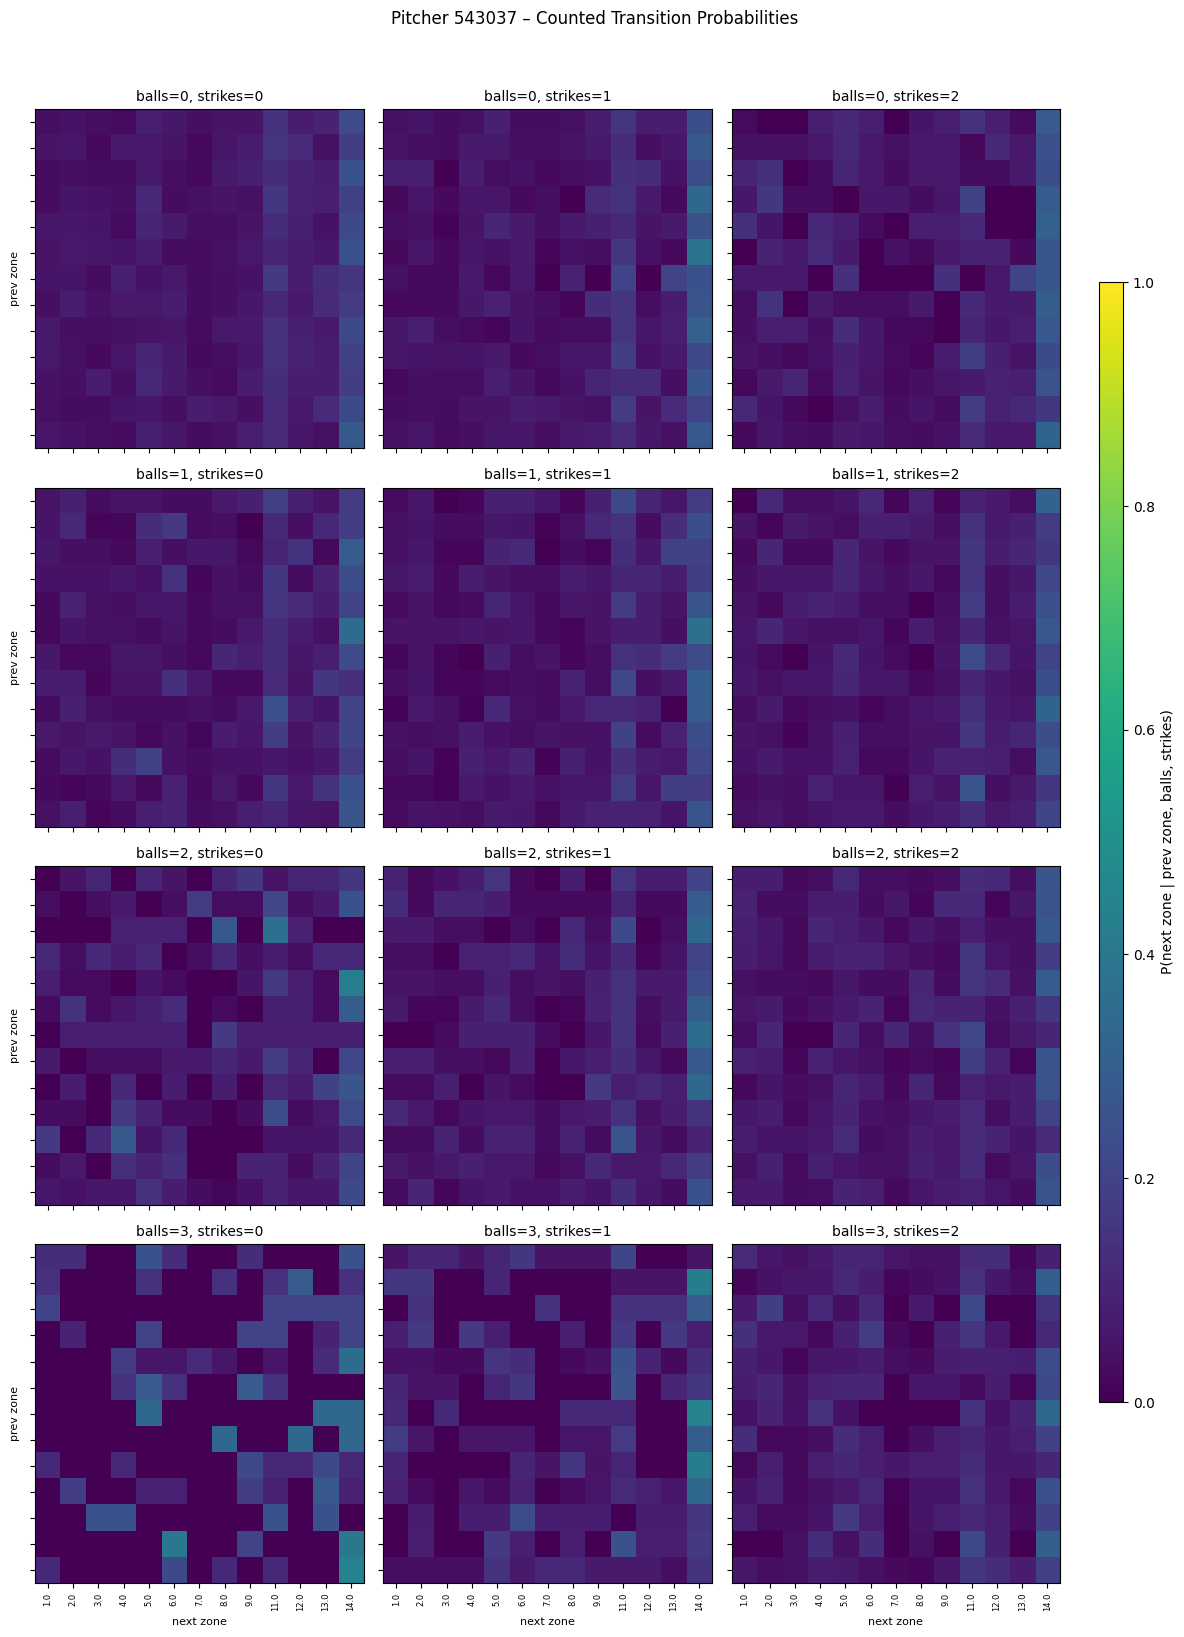


=== Pitcher 554430 の集計 ===


/tmp/ipykernel_697038/2594423863.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


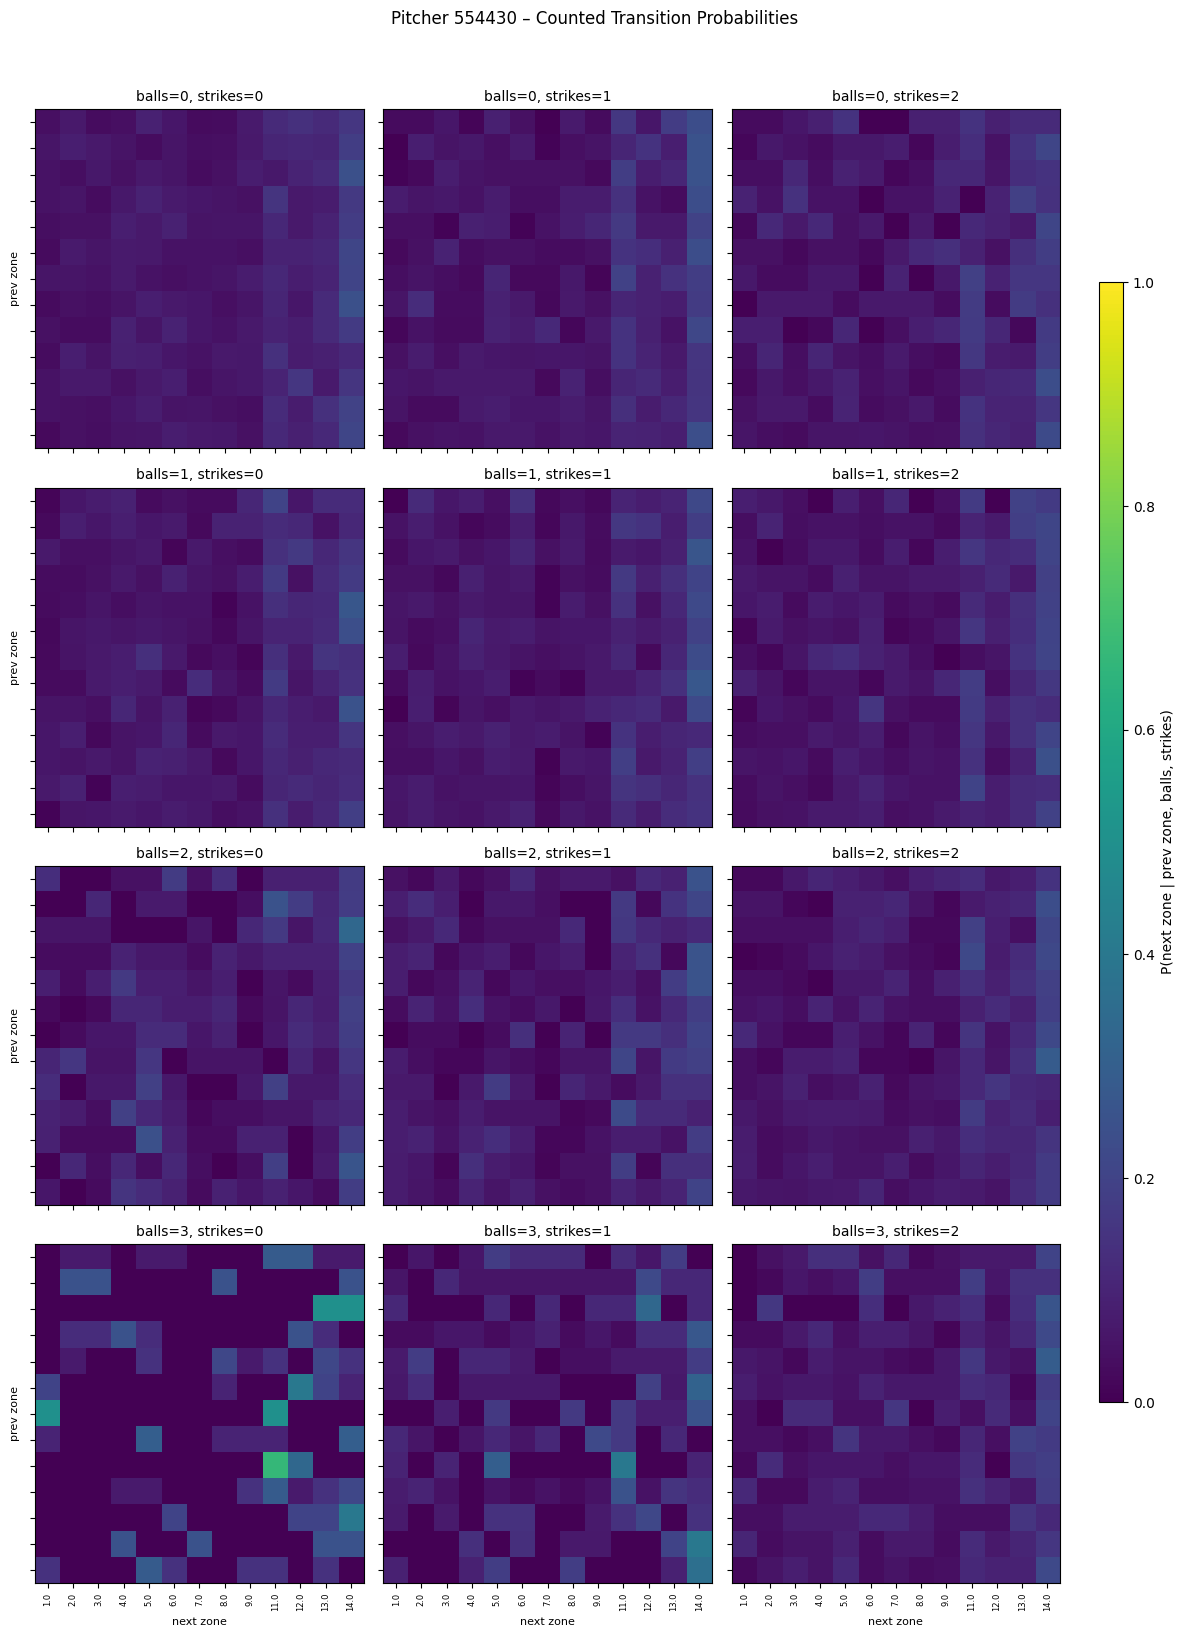


=== Pitcher 605400 の集計 ===


/tmp/ipykernel_697038/2594423863.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


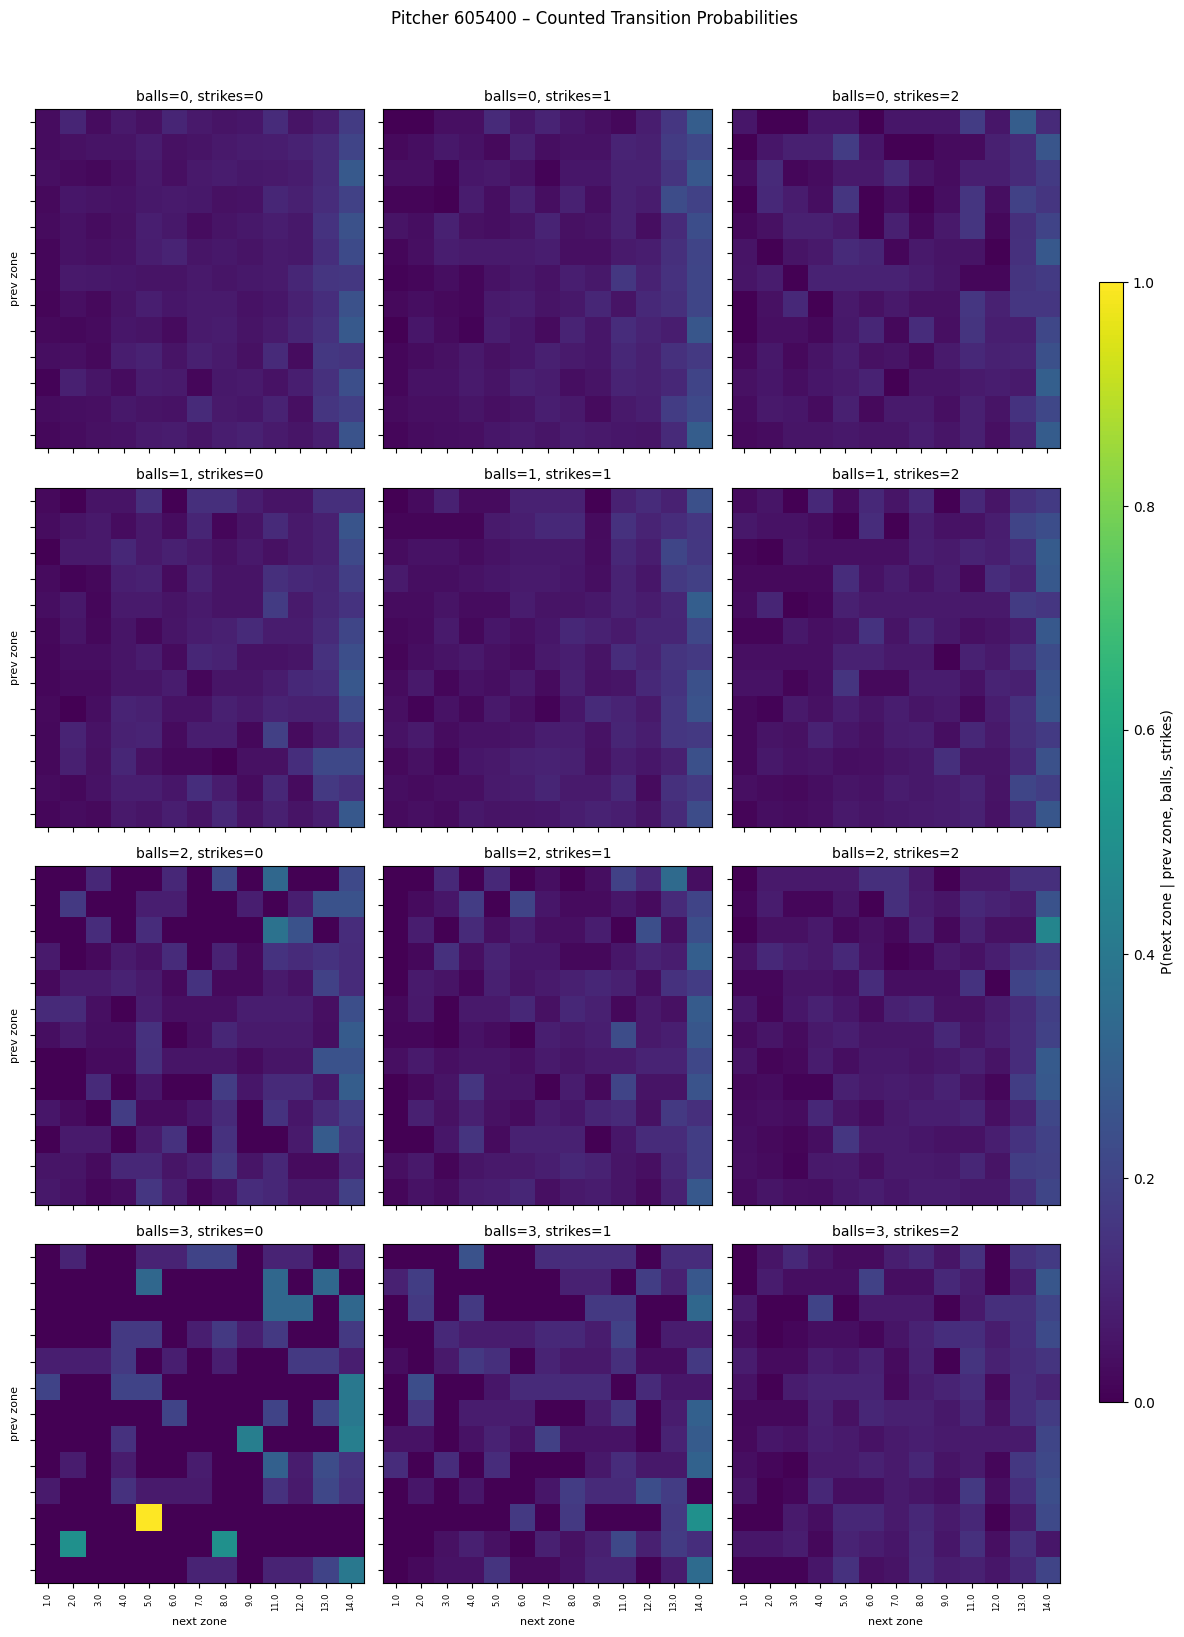


=== Pitcher 621244 の集計 ===


/tmp/ipykernel_697038/2594423863.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


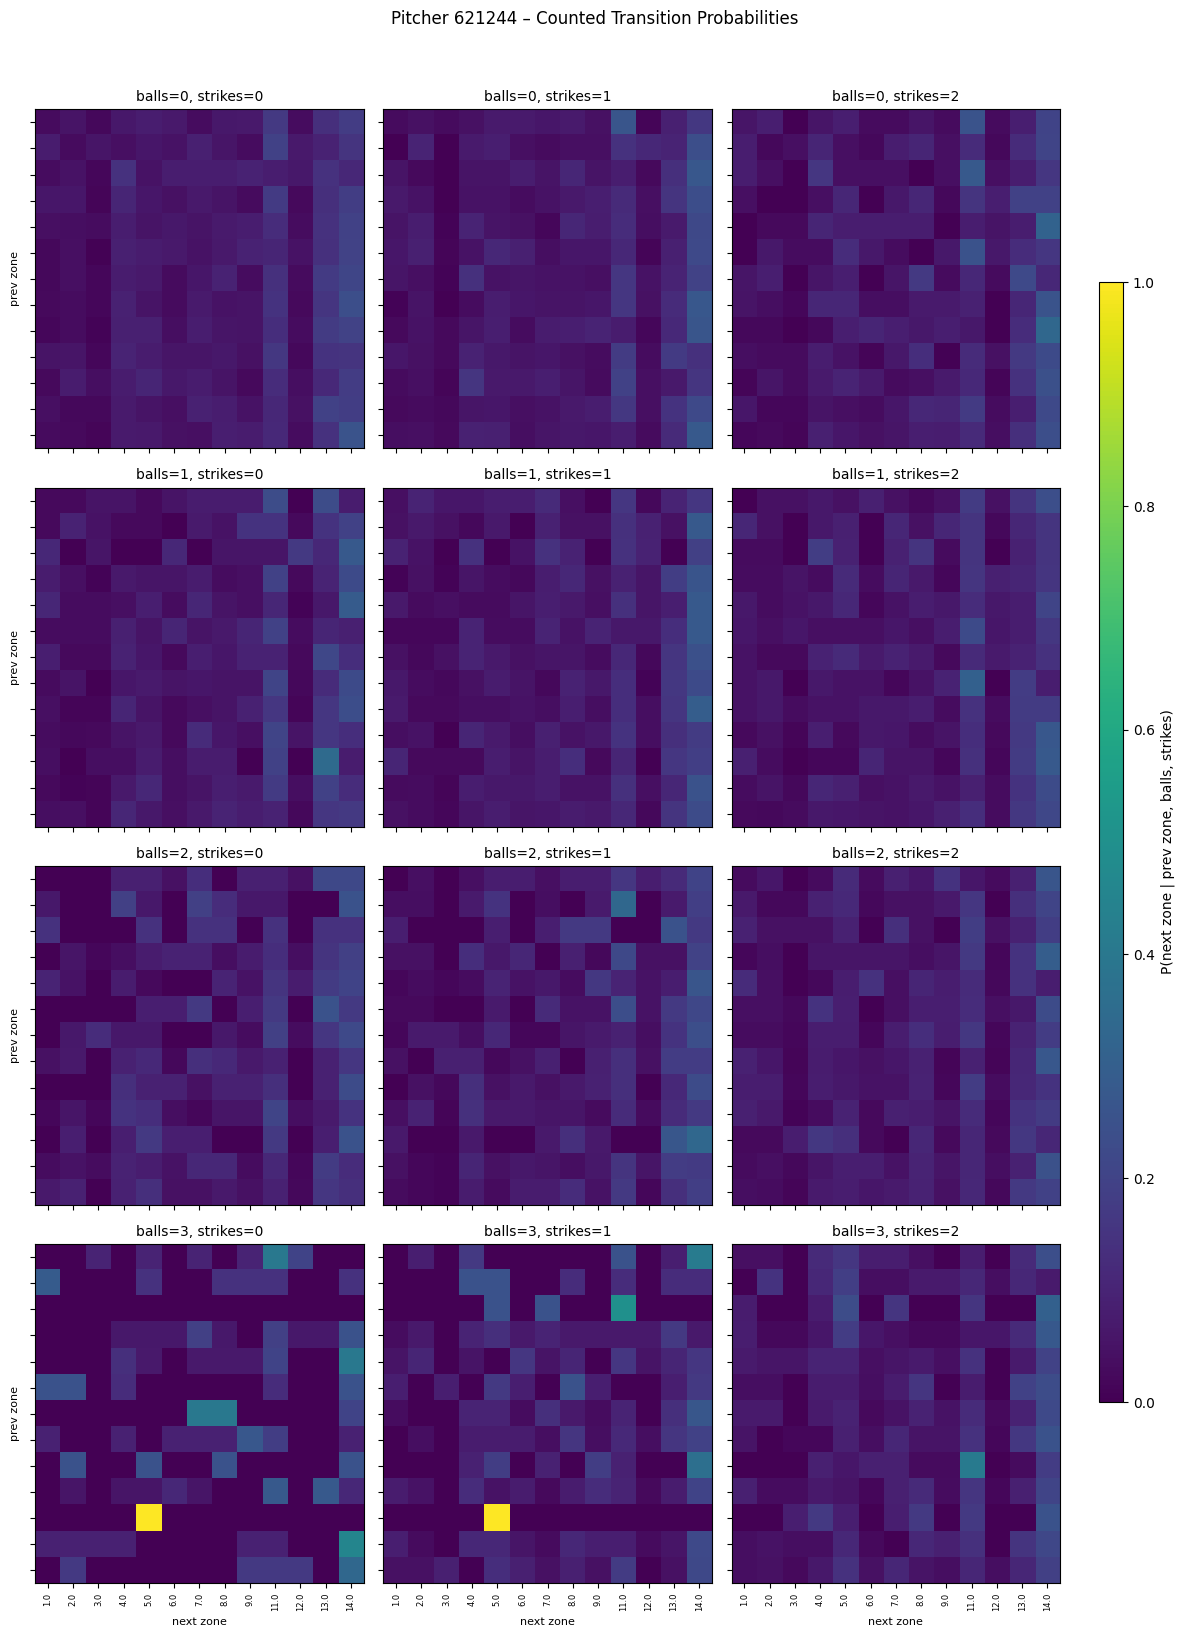


=== Pitcher 656302 の集計 ===


/tmp/ipykernel_697038/2594423863.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


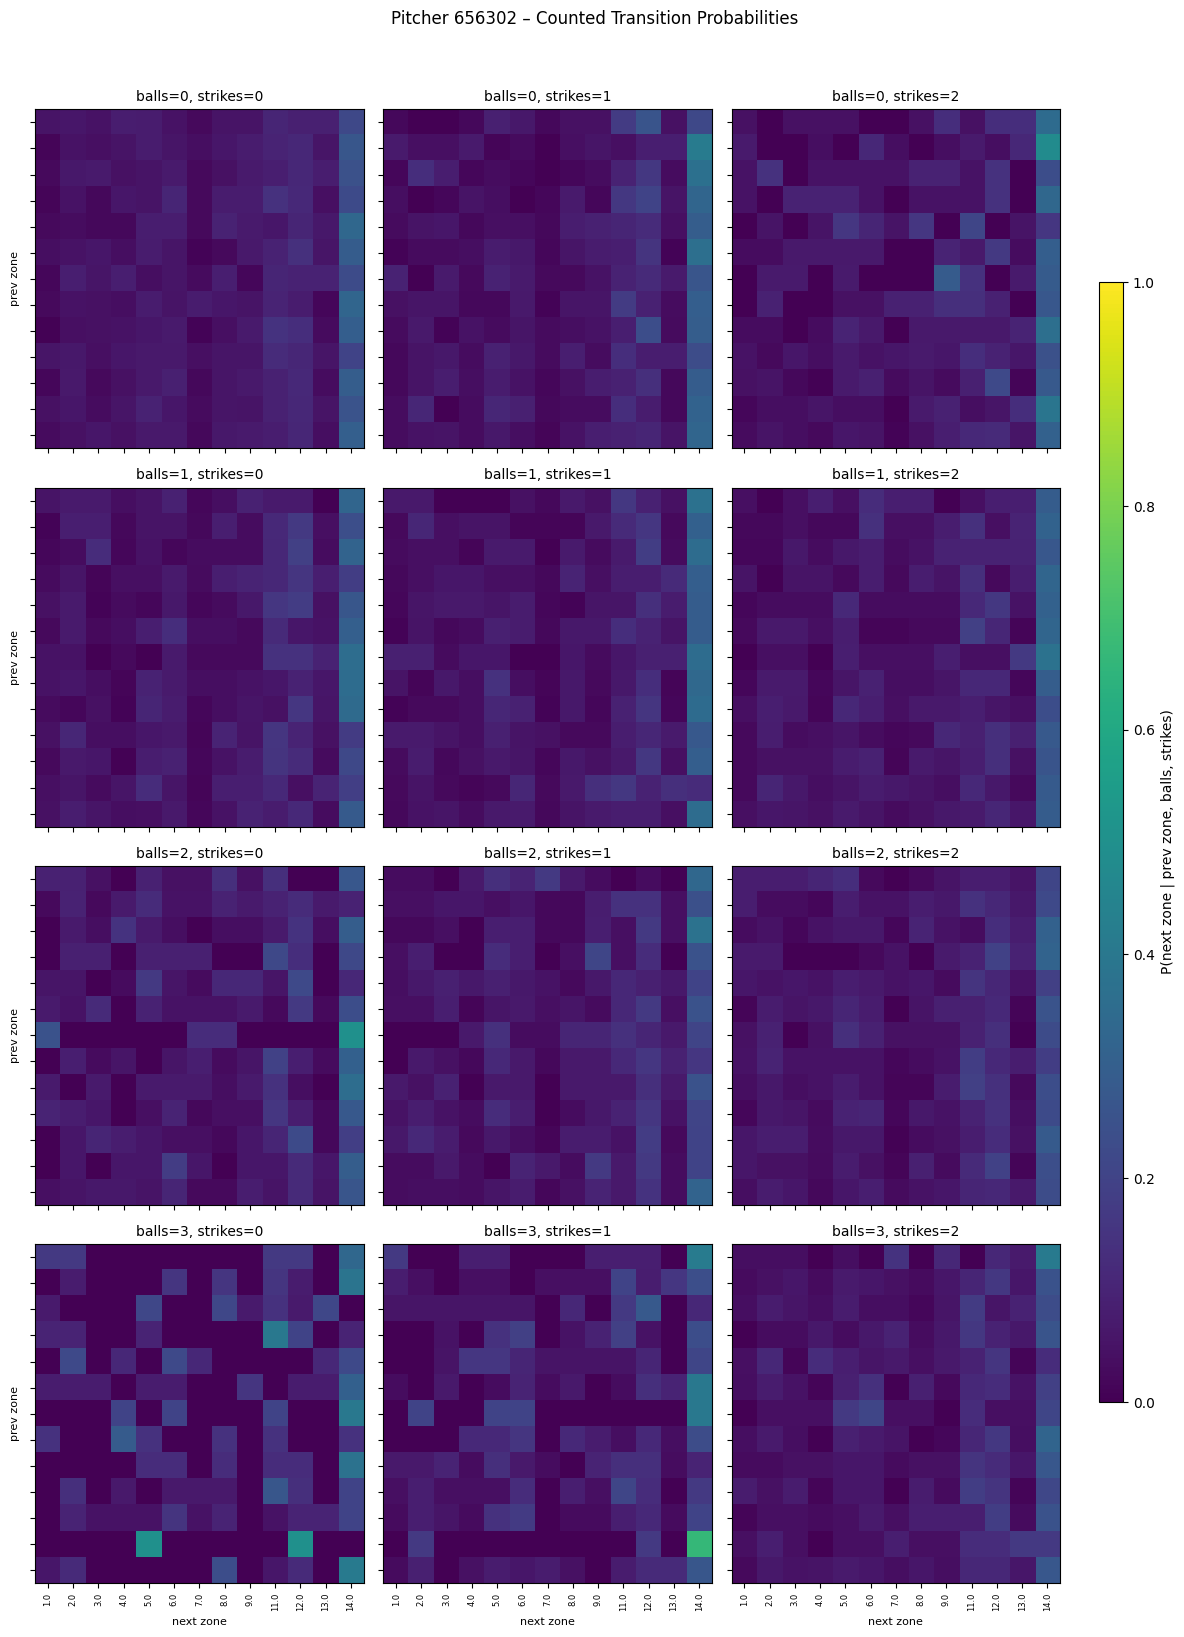

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# -----------------------------------------------------------------------------
# 前提：同じフォルダに 'df_clean_zone_cluster.csv' があるものとする
# -----------------------------------------------------------------------------
df_all = pd.read_csv('df_clean_zone_cluster.csv')

# -----------------------------------------------------------------------------
# 1) パラメータ定義
# -----------------------------------------------------------------------------
pitch_list = ["543037", "554430", "605400", "621244", "656302"]
covs       = [(b, s) for b in range(4) for s in range(3)]

all_zones = np.sort(df_all['zone'].unique())
K = len(all_zones)
zone_to_idx = {z: i for i, z in enumerate(all_zones)}
idx_to_zone = {i: z for i, z in enumerate(all_zones)}

# -----------------------------------------------------------------------------
# 2) 投手ごとに集計＆プロット
# -----------------------------------------------------------------------------
for pid in pitch_list:
    print(f"\n=== Pitcher {pid} の集計 ===")
    # 投手ID は文字列なので、df_all['pitcher'] も文字列に揃えておく
    df_p = df_all[df_all['pitcher'].astype(str) == pid].sort_values('game_pk').reset_index(drop=True)
    if df_p.empty:
        print(f" データが見つかりません（スキップ）")
        continue

    # (A) 遷移集計用レコード作成
    records = []
    for _, grp in df_p.groupby('game_pk'):
        bs_vals   = grp[['balls','strikes']].values
        zone_vals = grp['zone'].values
        if len(zone_vals) < 2:
            continue
        for i in range(len(zone_vals) - 1):
            b, s      = bs_vals[i]
            prev_z    = zone_to_idx[int(zone_vals[i])]
            next_z    = zone_to_idx[int(zone_vals[i + 1])]
            records.append((b, s, prev_z, next_z))

    if not records:
        print(" 遷移サンプルなし（スキップ）")
        continue

    df_trans = pd.DataFrame(records, columns=['balls','strikes','prev_z','next_z'])

    # (B) (balls,strikes) ごとの遷移確率をカウント＆正規化
    trans_prob_dict = {}
    for b, s in covs:
        tmp = df_trans[(df_trans['balls'] == b) & (df_trans['strikes'] == s)]
        if tmp.empty:
            continue
        cm = tmp.pivot_table(index='prev_z', columns='next_z', aggfunc='size', fill_value=0)
        # K×K 行列に補完
        cm = cm.reindex(index=range(K), columns=range(K), fill_value=0)
        row_sums = cm.sum(axis=1).values.reshape(-1, 1)
        trans_prob = cm.div(row_sums, axis=0).fillna(0)
        trans_prob_dict[(b, s)] = trans_prob

    # (C) プロット 4×3 グリッド
    n_cov  = len(covs)
    n_cols = 3
    n_rows = ceil(n_cov / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)
    fig.suptitle(f"Pitcher {pid} – Counted Transition Probabilities", y=1.02)

    axes = axes.flatten()
    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        if (b, s) in trans_prob_dict:
            mat = trans_prob_dict[(b, s)].values
        else:
            mat = np.zeros((K, K))

        # cmap='viridis' と文字列指定すれば cm が上書きされていても動作する
        im = ax.imshow(mat, vmin=0.0, vmax=1.0, aspect='auto', cmap='viridis')
        ax.set_title(f"balls={b}, strikes={s}", fontsize=10)
        ax.set_xticks(np.arange(K))
        ax.set_yticks(np.arange(K))
        ax.set_xticklabels([idx_to_zone[i] for i in range(K)], rotation=90, fontsize=6)
        ax.set_yticklabels([idx_to_zone[i] for i in range(K)],           fontsize=6)

        # 最下段だけ x 軸ラベルを表示
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("next zone", fontsize=8)
        else:
            ax.set_xticklabels([])

        # 最左列だけ y 軸ラベルを表示
        if idx % n_cols == 0:
            ax.set_ylabel("prev zone", fontsize=8)
        else:
            ax.set_yticklabels([])

    # 余った subplot をオフ
    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    # カラーバーを右側にまとめて出す
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(next zone | prev zone, balls, strikes)")

    plt.tight_layout(rect=[0, 0, 0.9, 1.0])
    plt.show()



=== Pitcher 543037 の集計 ===


/tmp/ipykernel_697038/2191143804.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


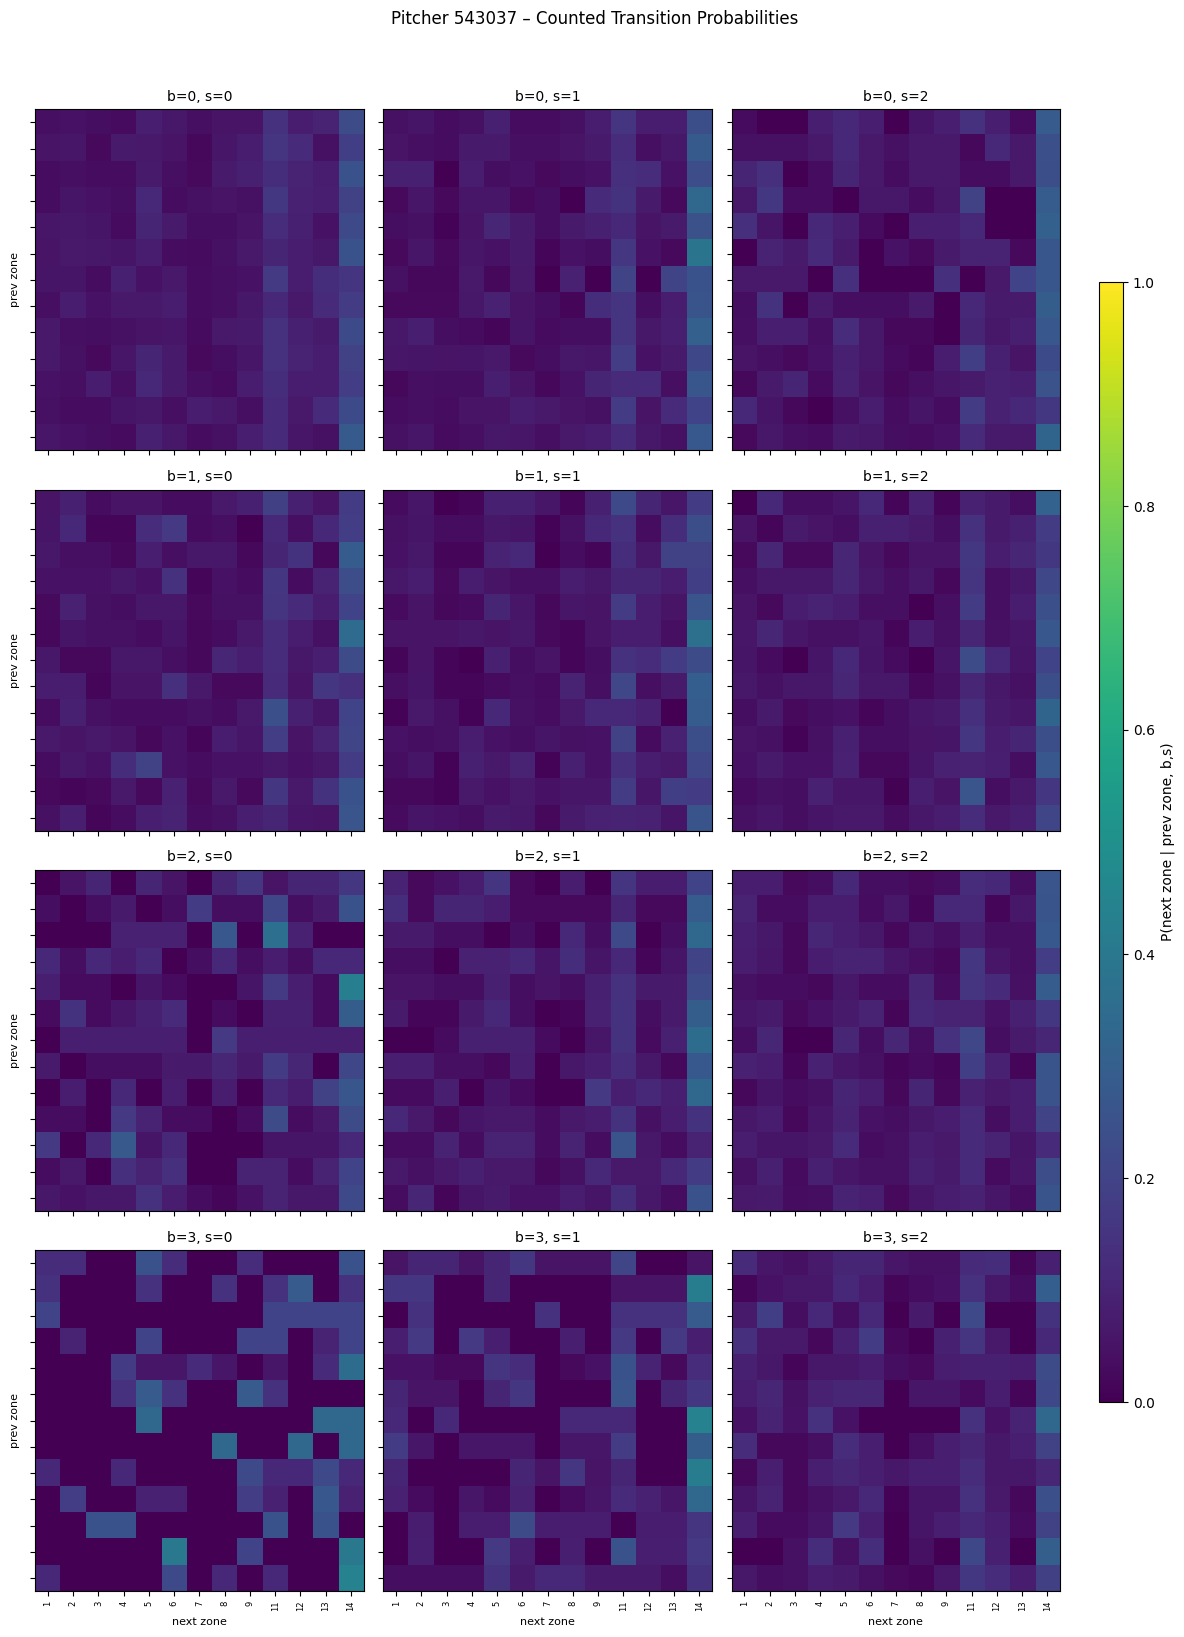

/tmp/ipykernel_697038/2191143804.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


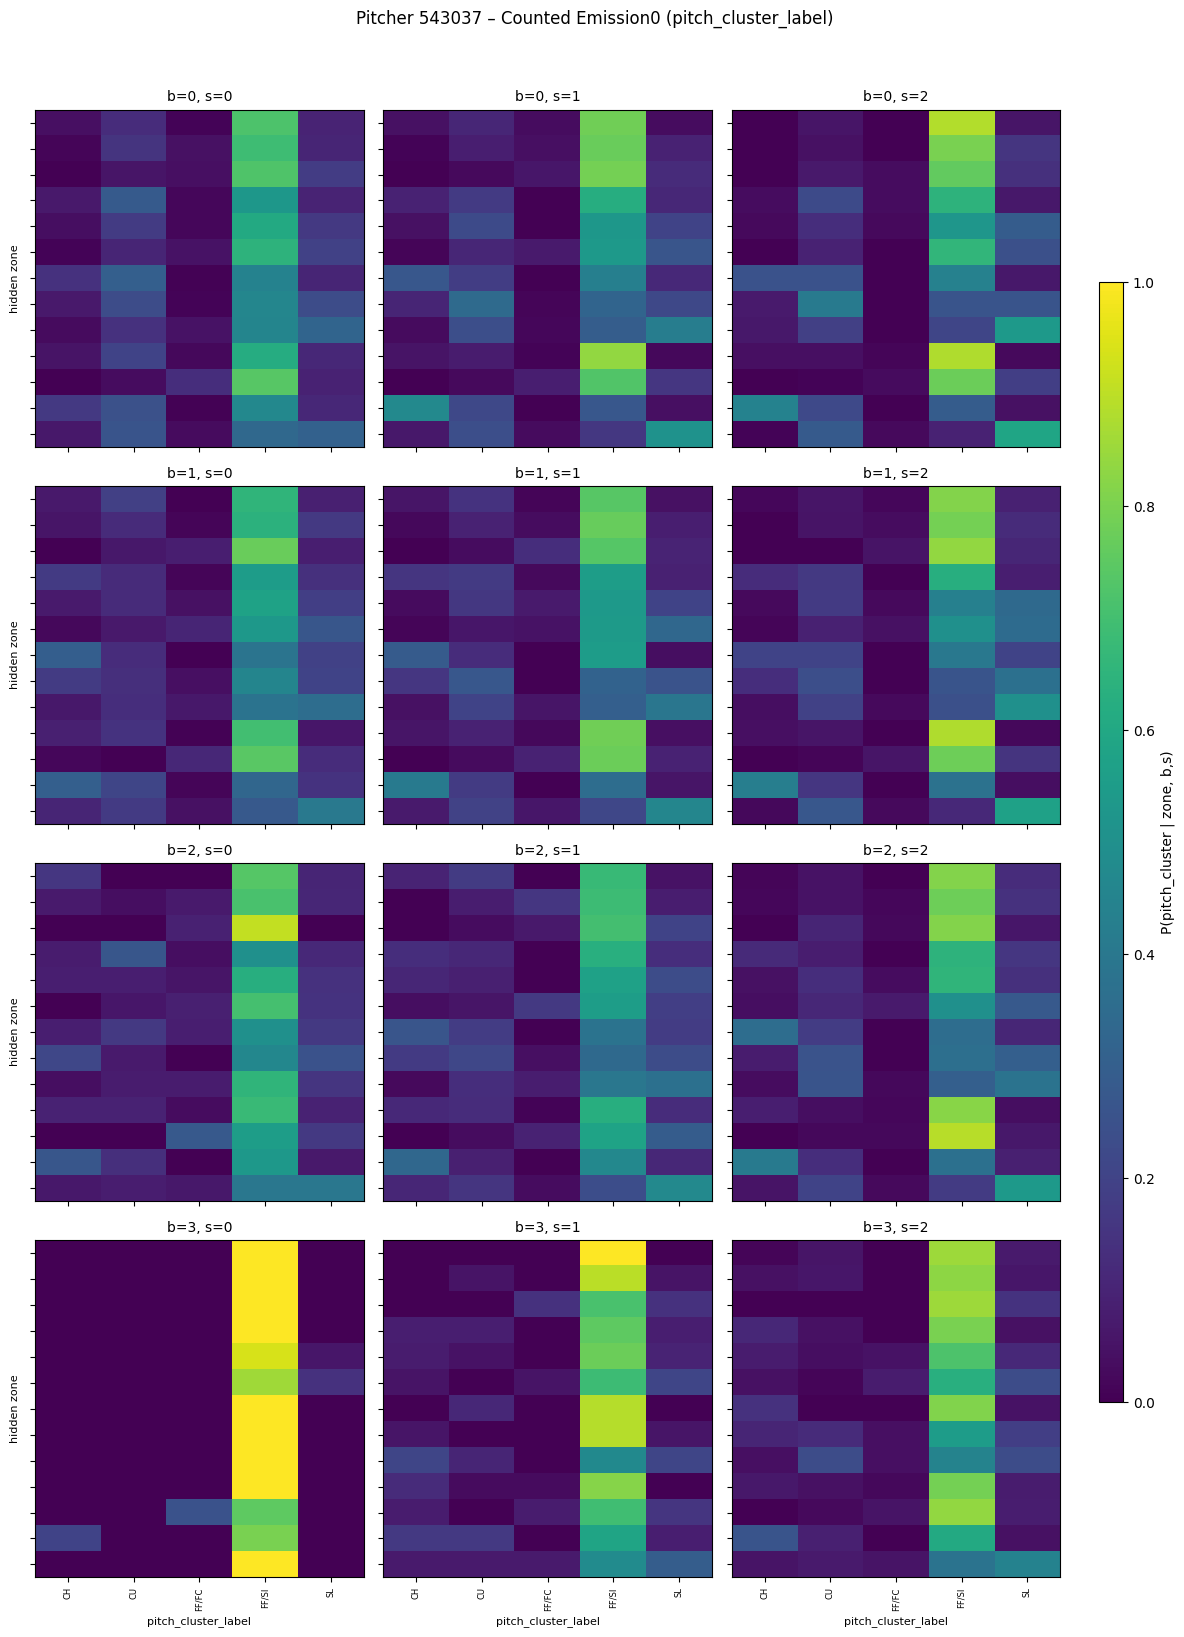

/tmp/ipykernel_697038/2191143804.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


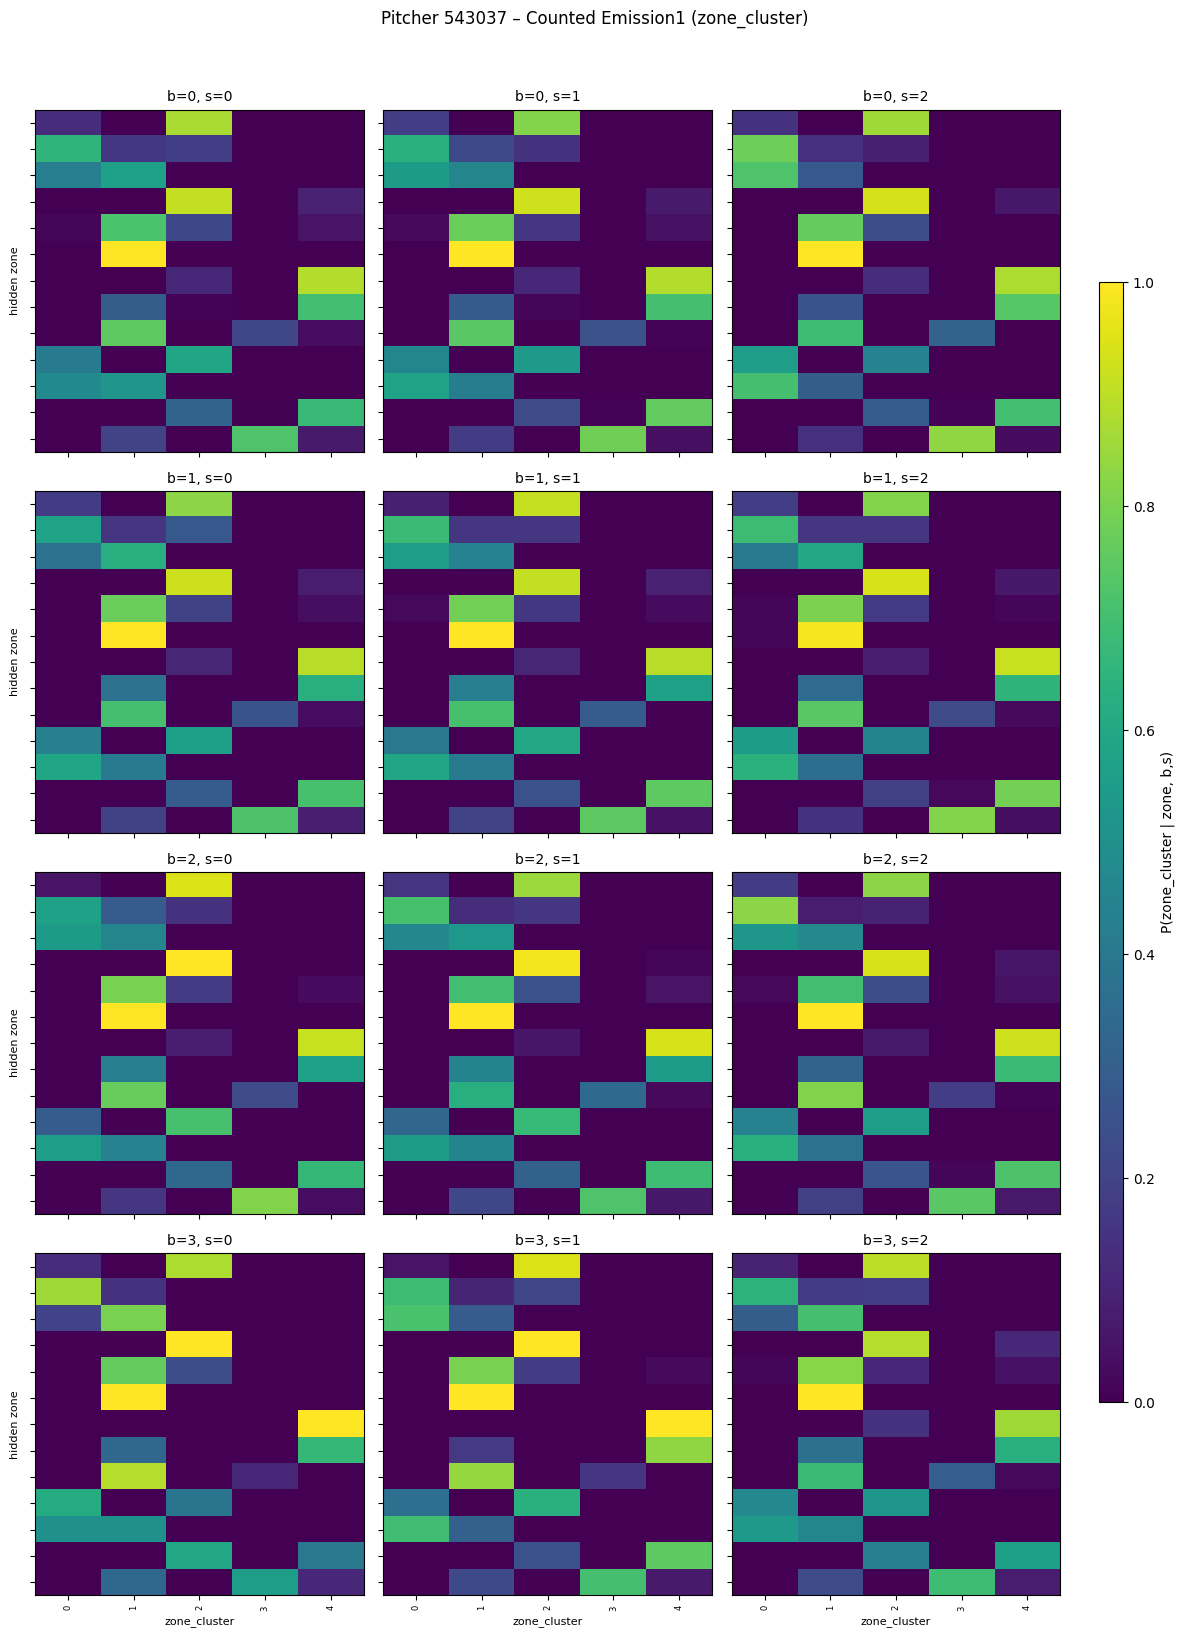


=== Pitcher 554430 の集計 ===


/tmp/ipykernel_697038/2191143804.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


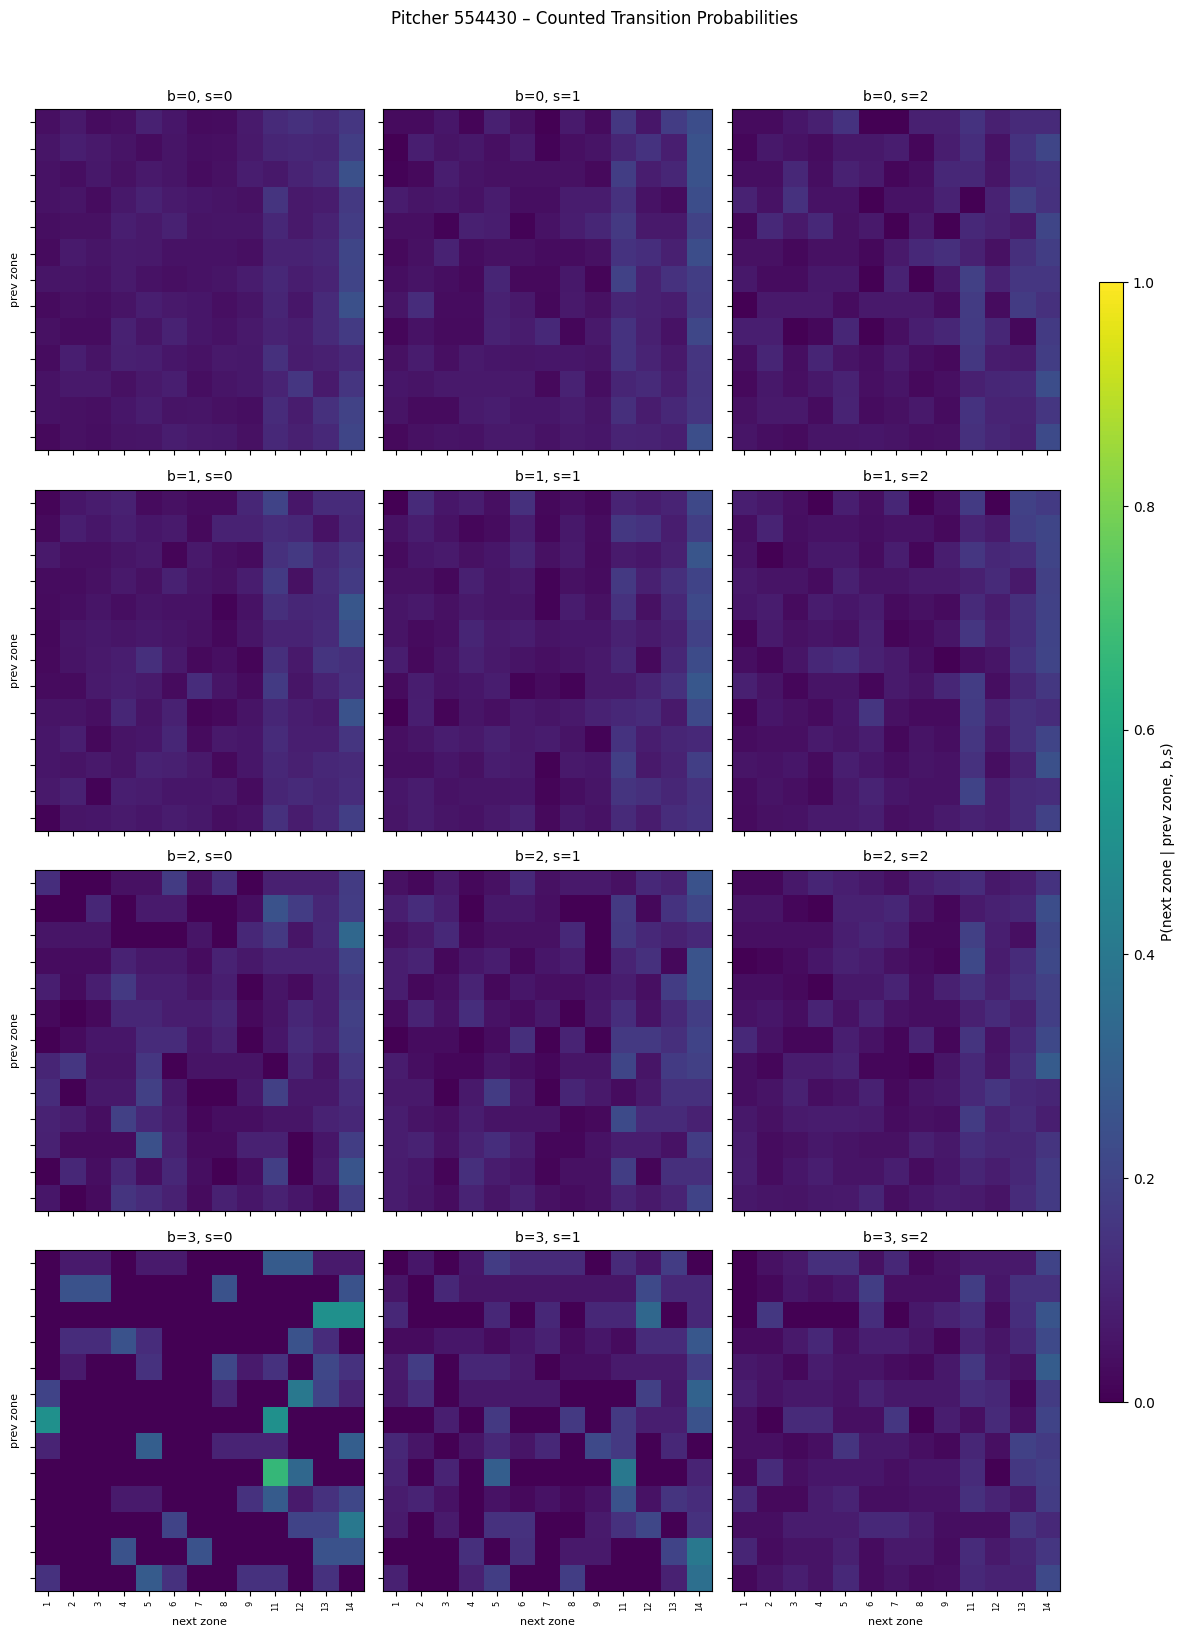

/tmp/ipykernel_697038/2191143804.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


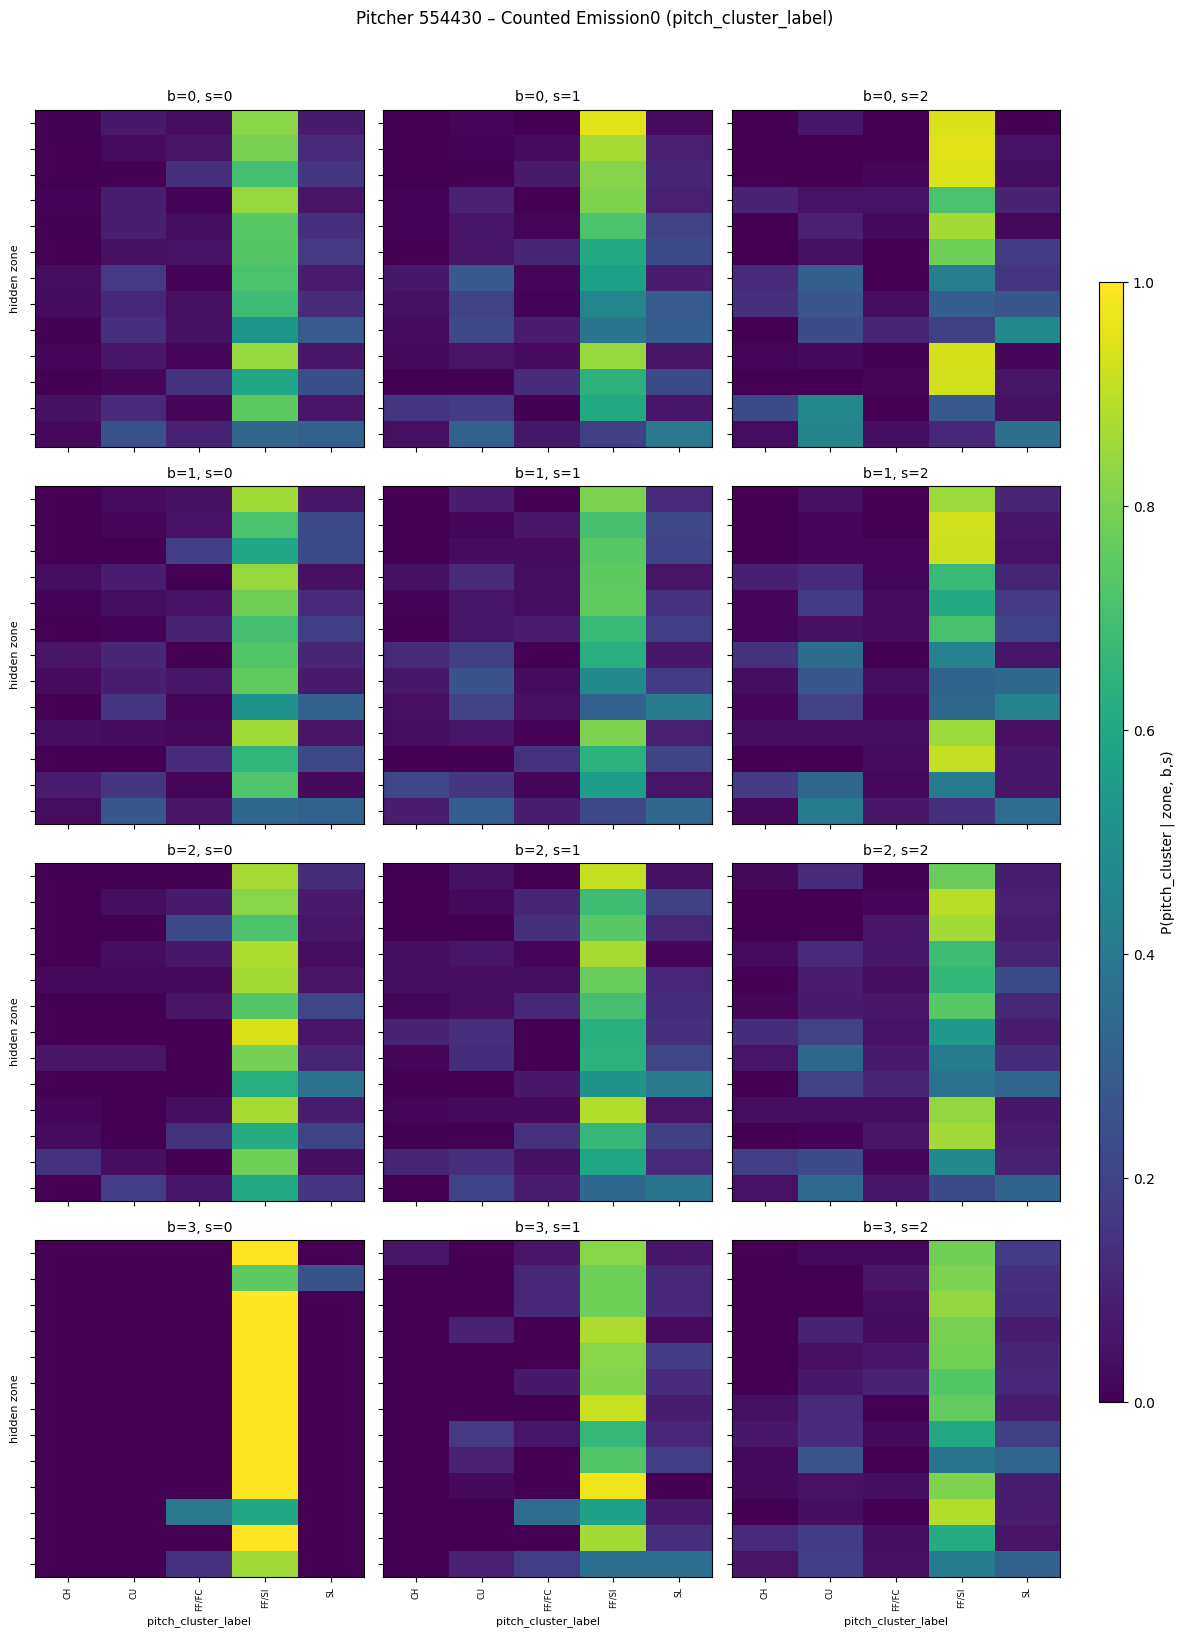

/tmp/ipykernel_697038/2191143804.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


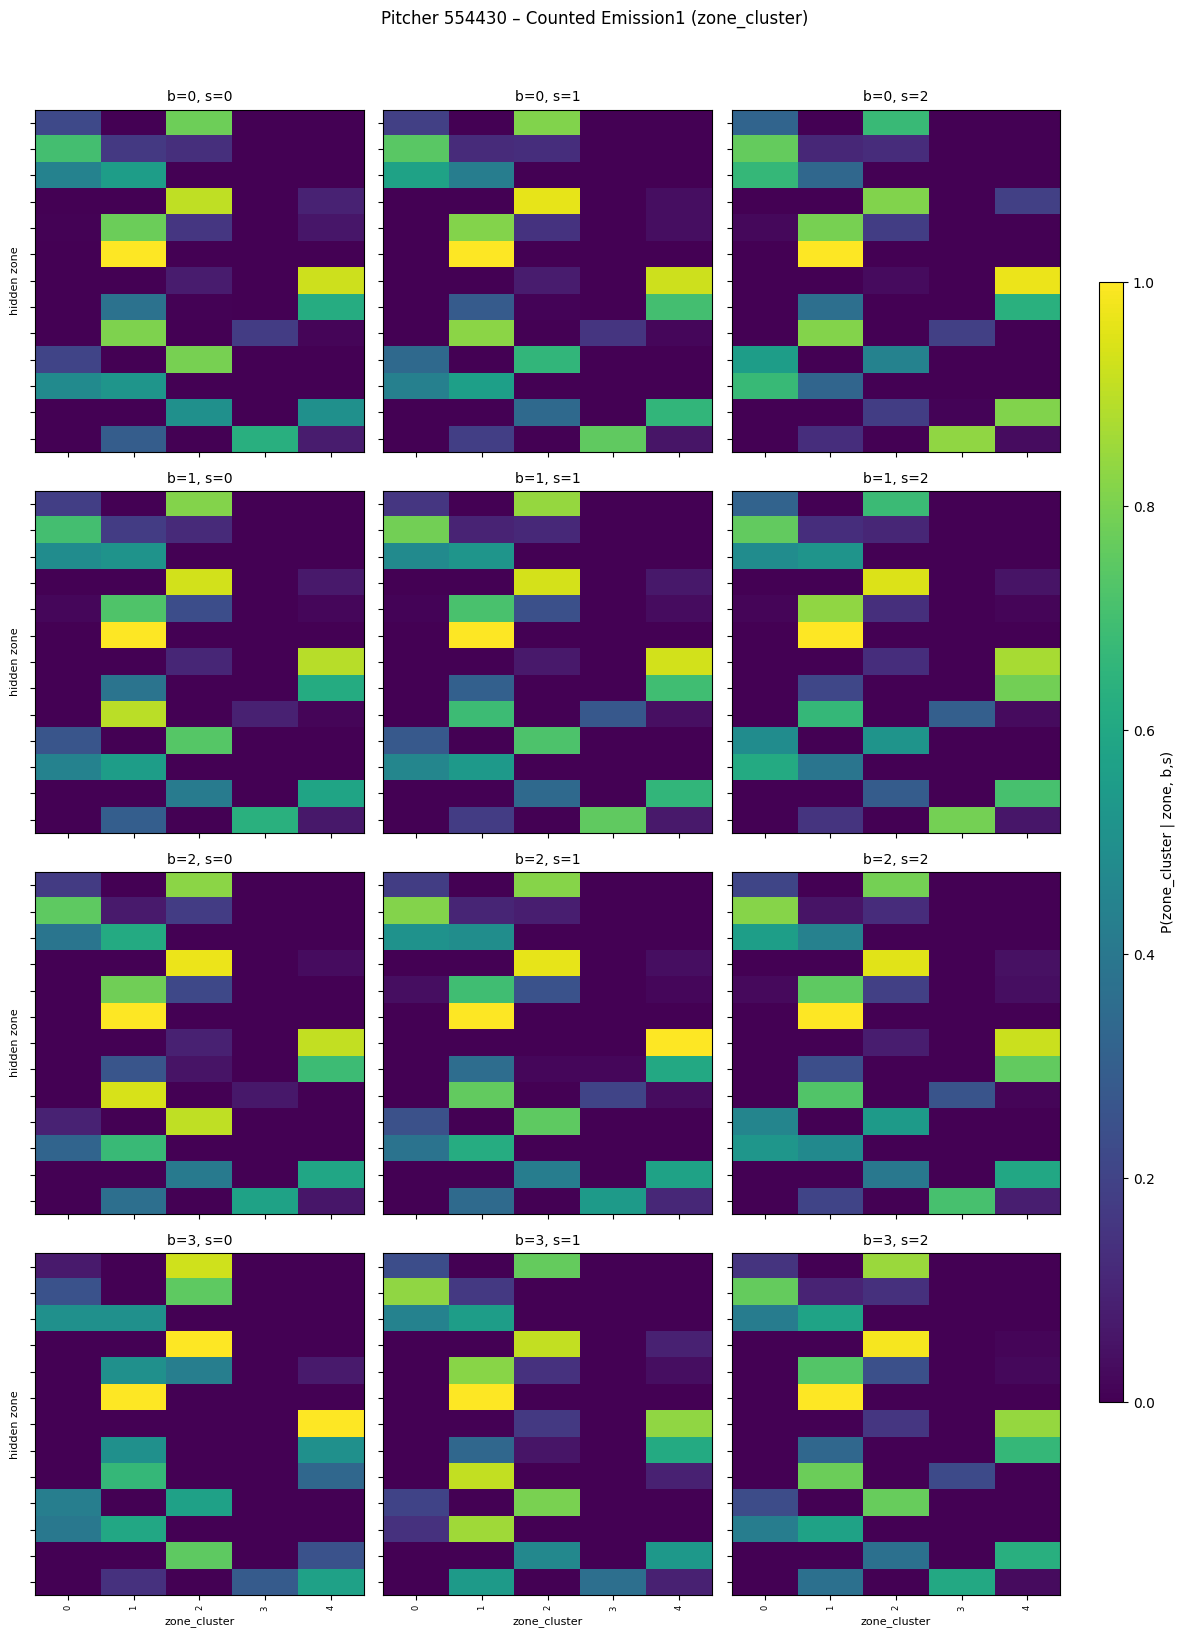


=== Pitcher 605400 の集計 ===


/tmp/ipykernel_697038/2191143804.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


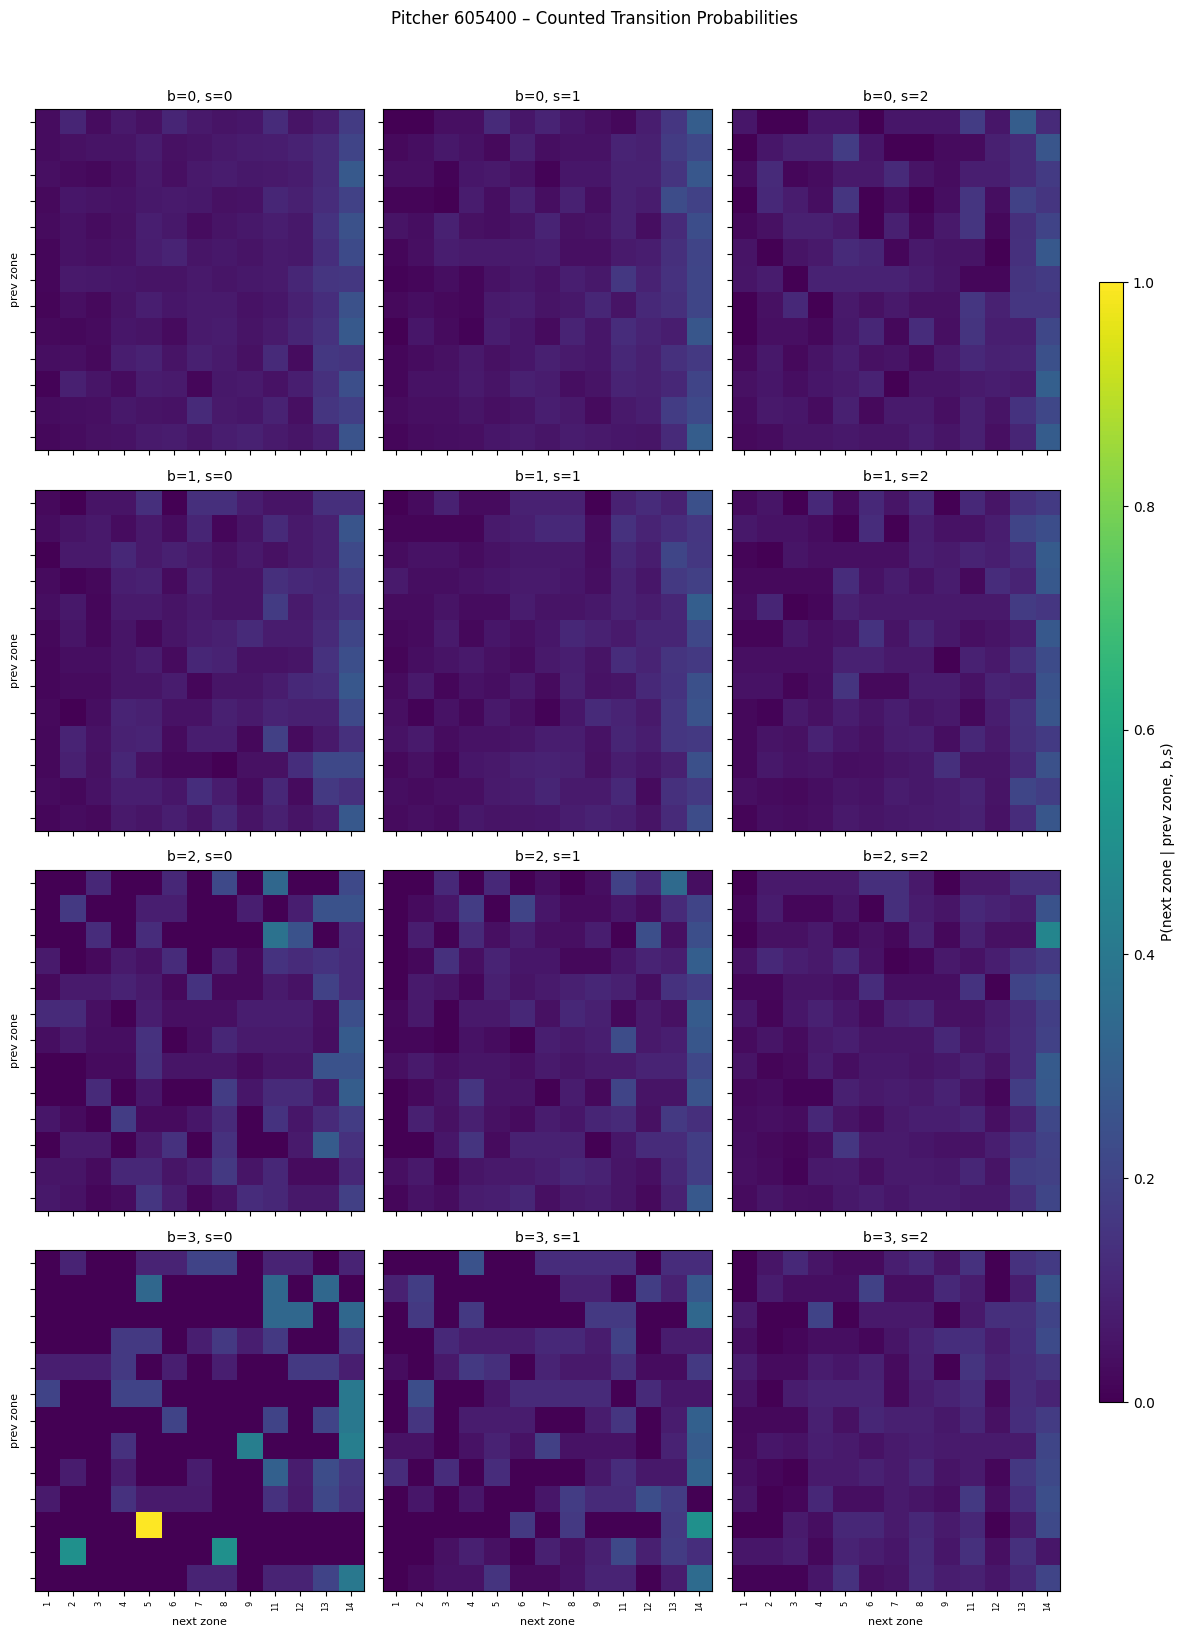

/tmp/ipykernel_697038/2191143804.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


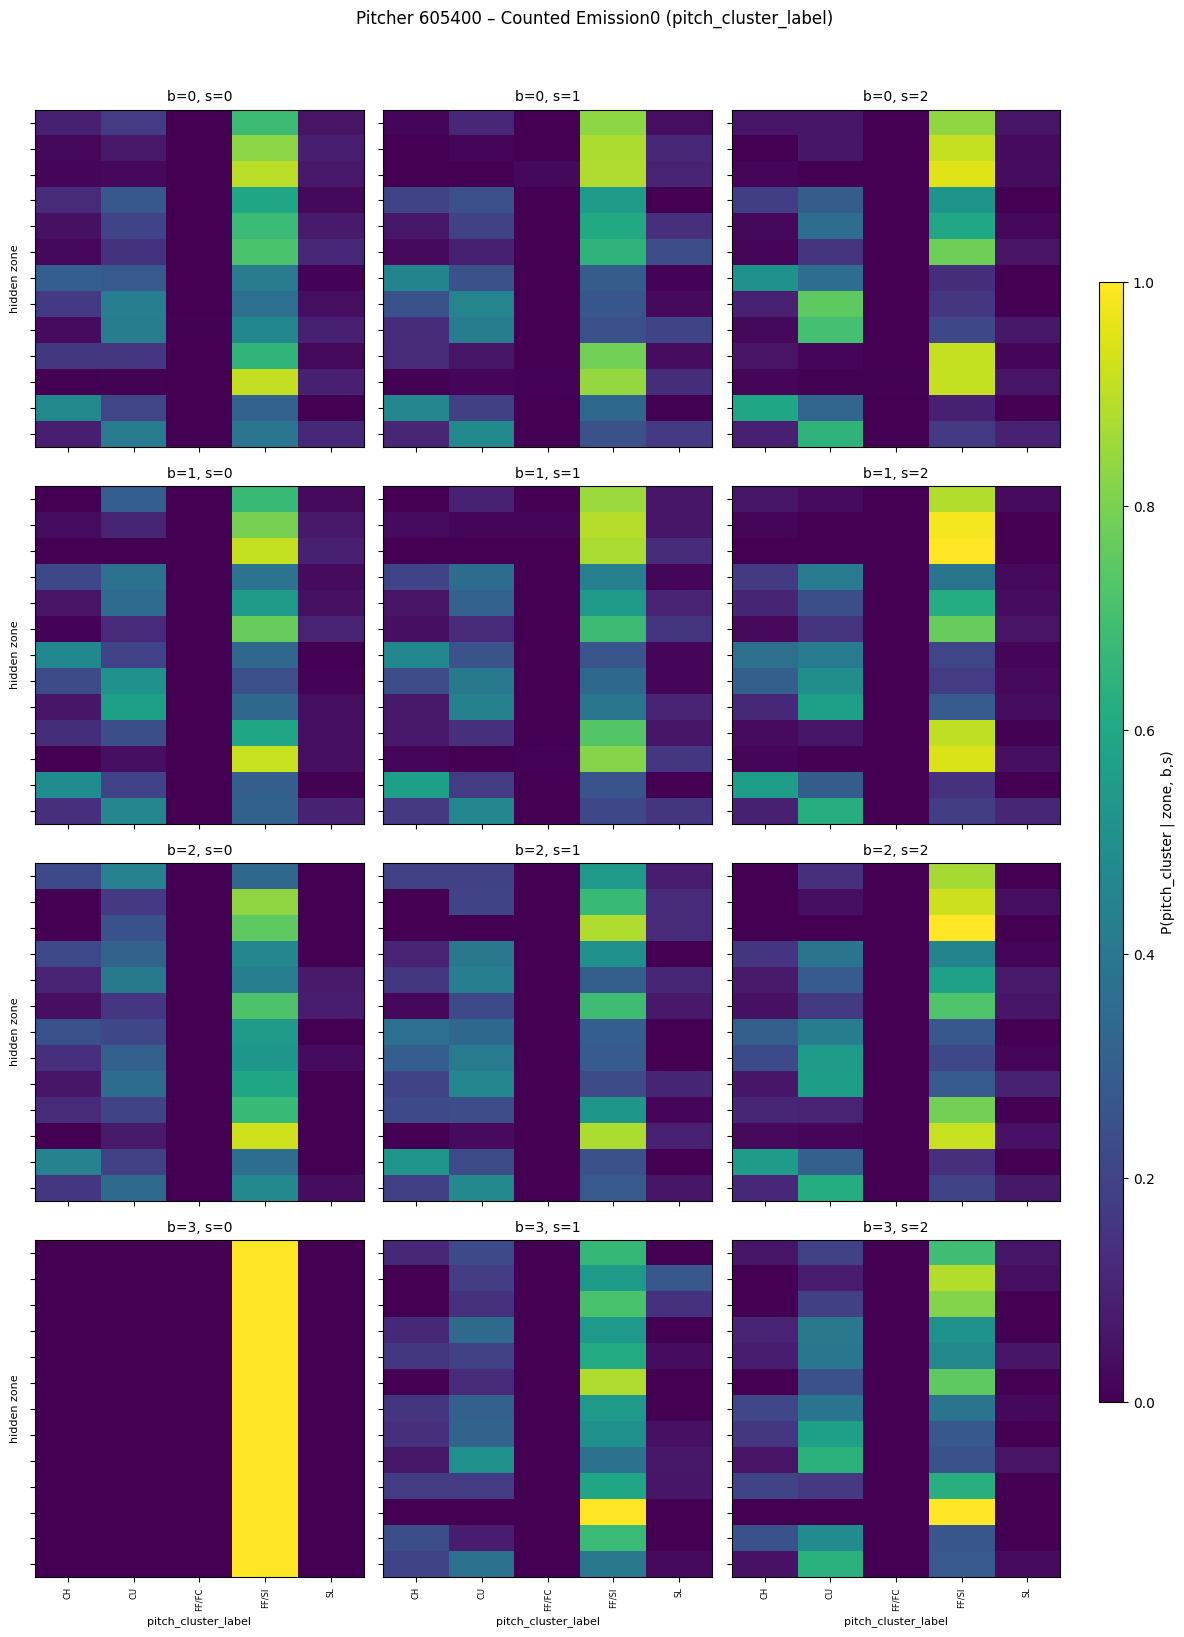

/tmp/ipykernel_697038/2191143804.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


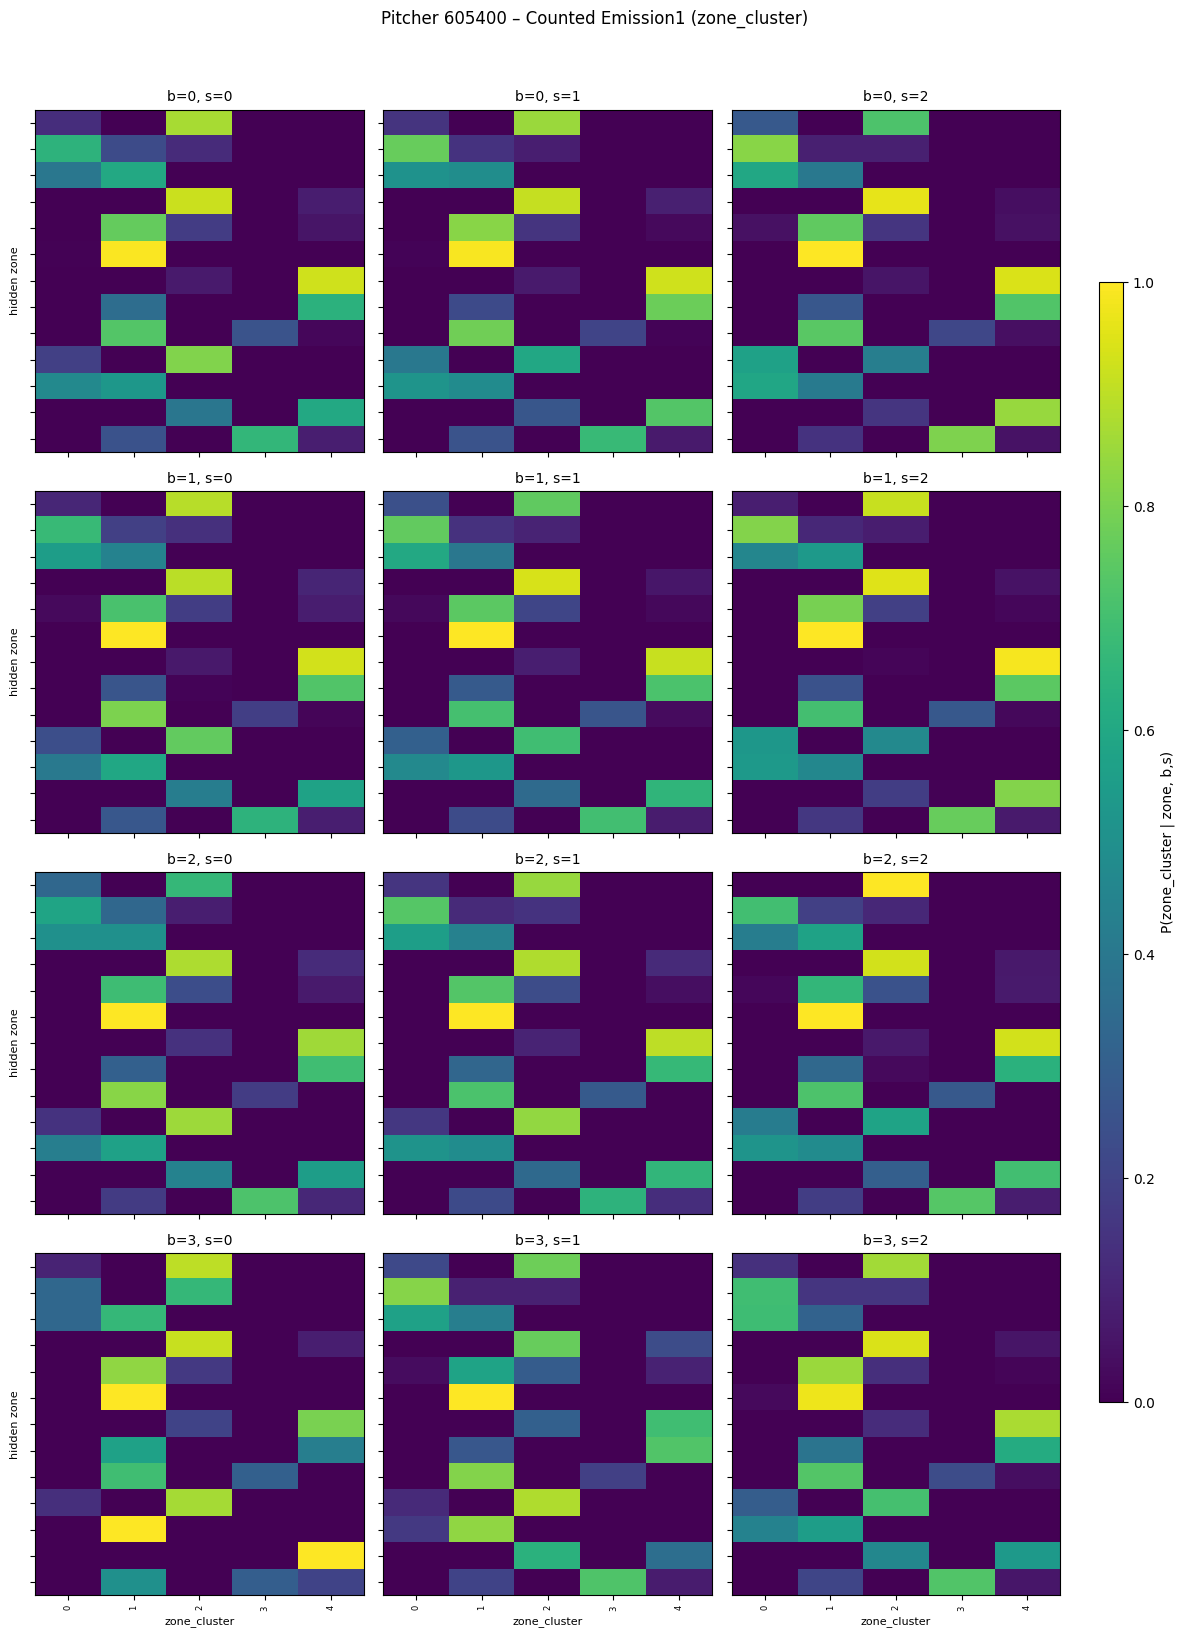


=== Pitcher 621244 の集計 ===


/tmp/ipykernel_697038/2191143804.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


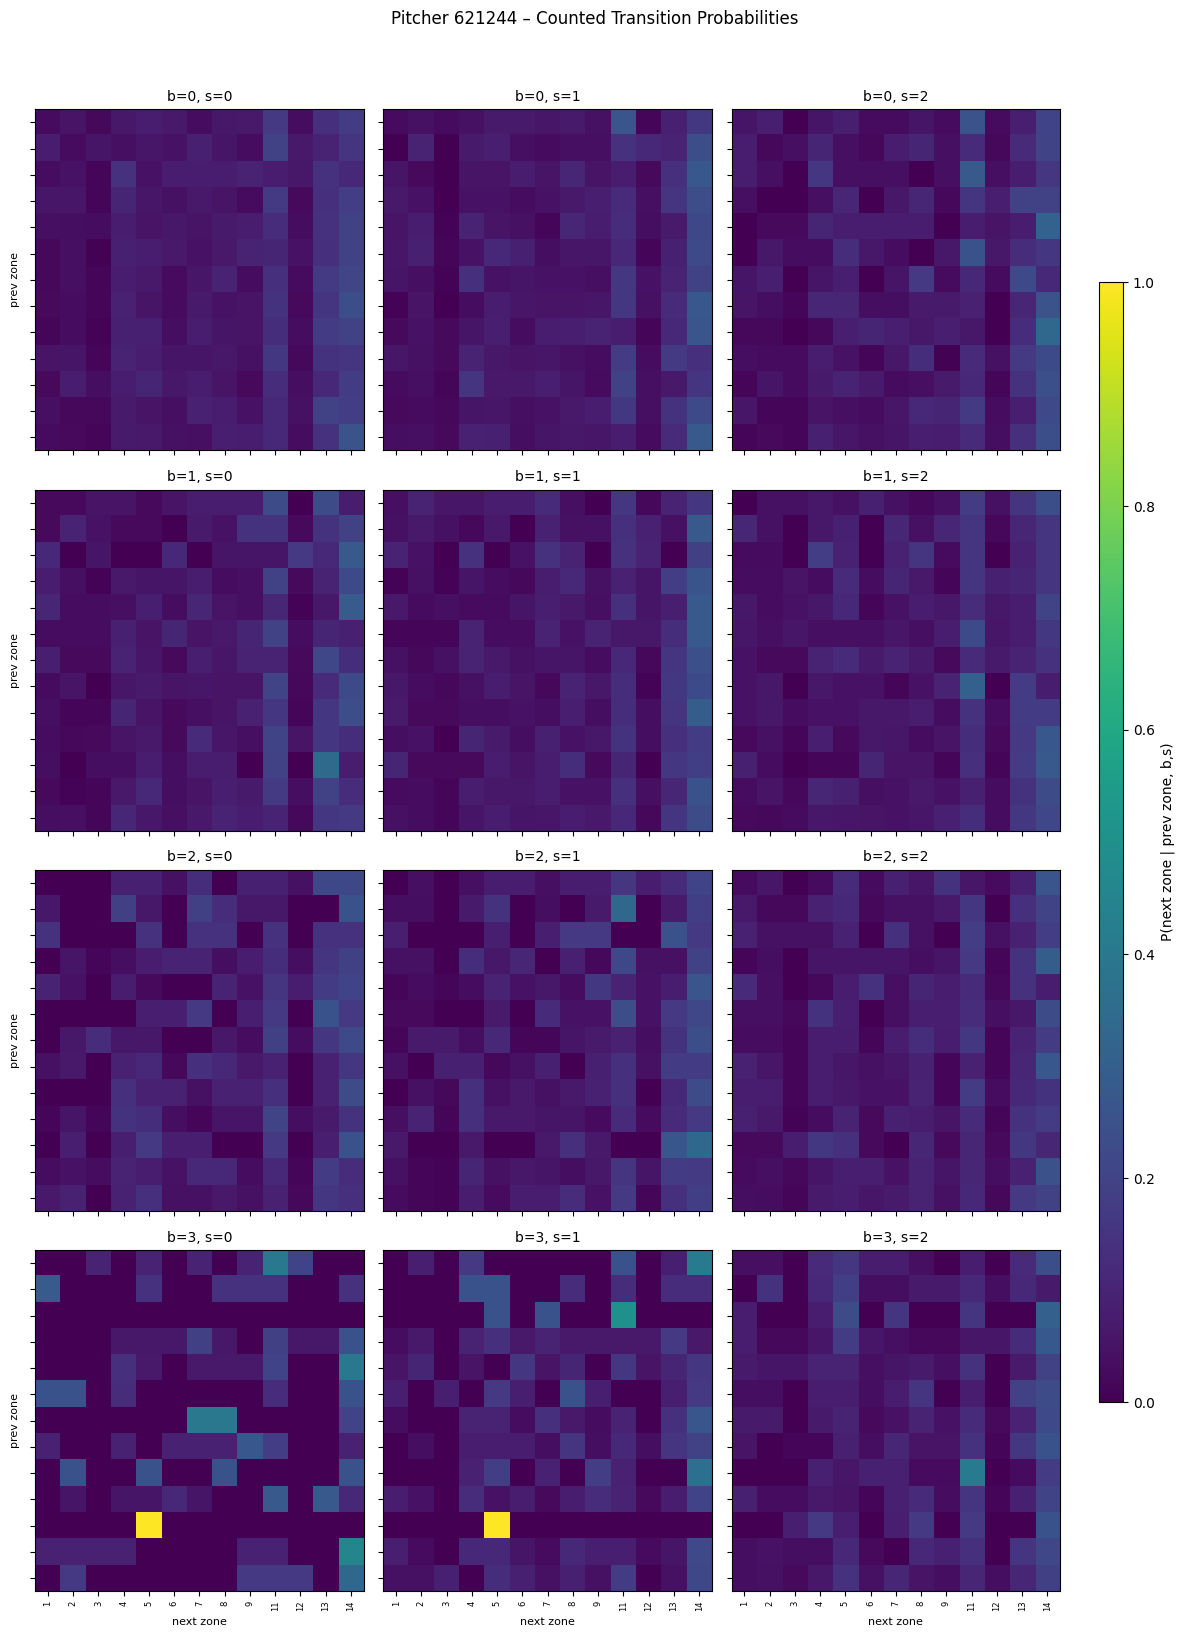

/tmp/ipykernel_697038/2191143804.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


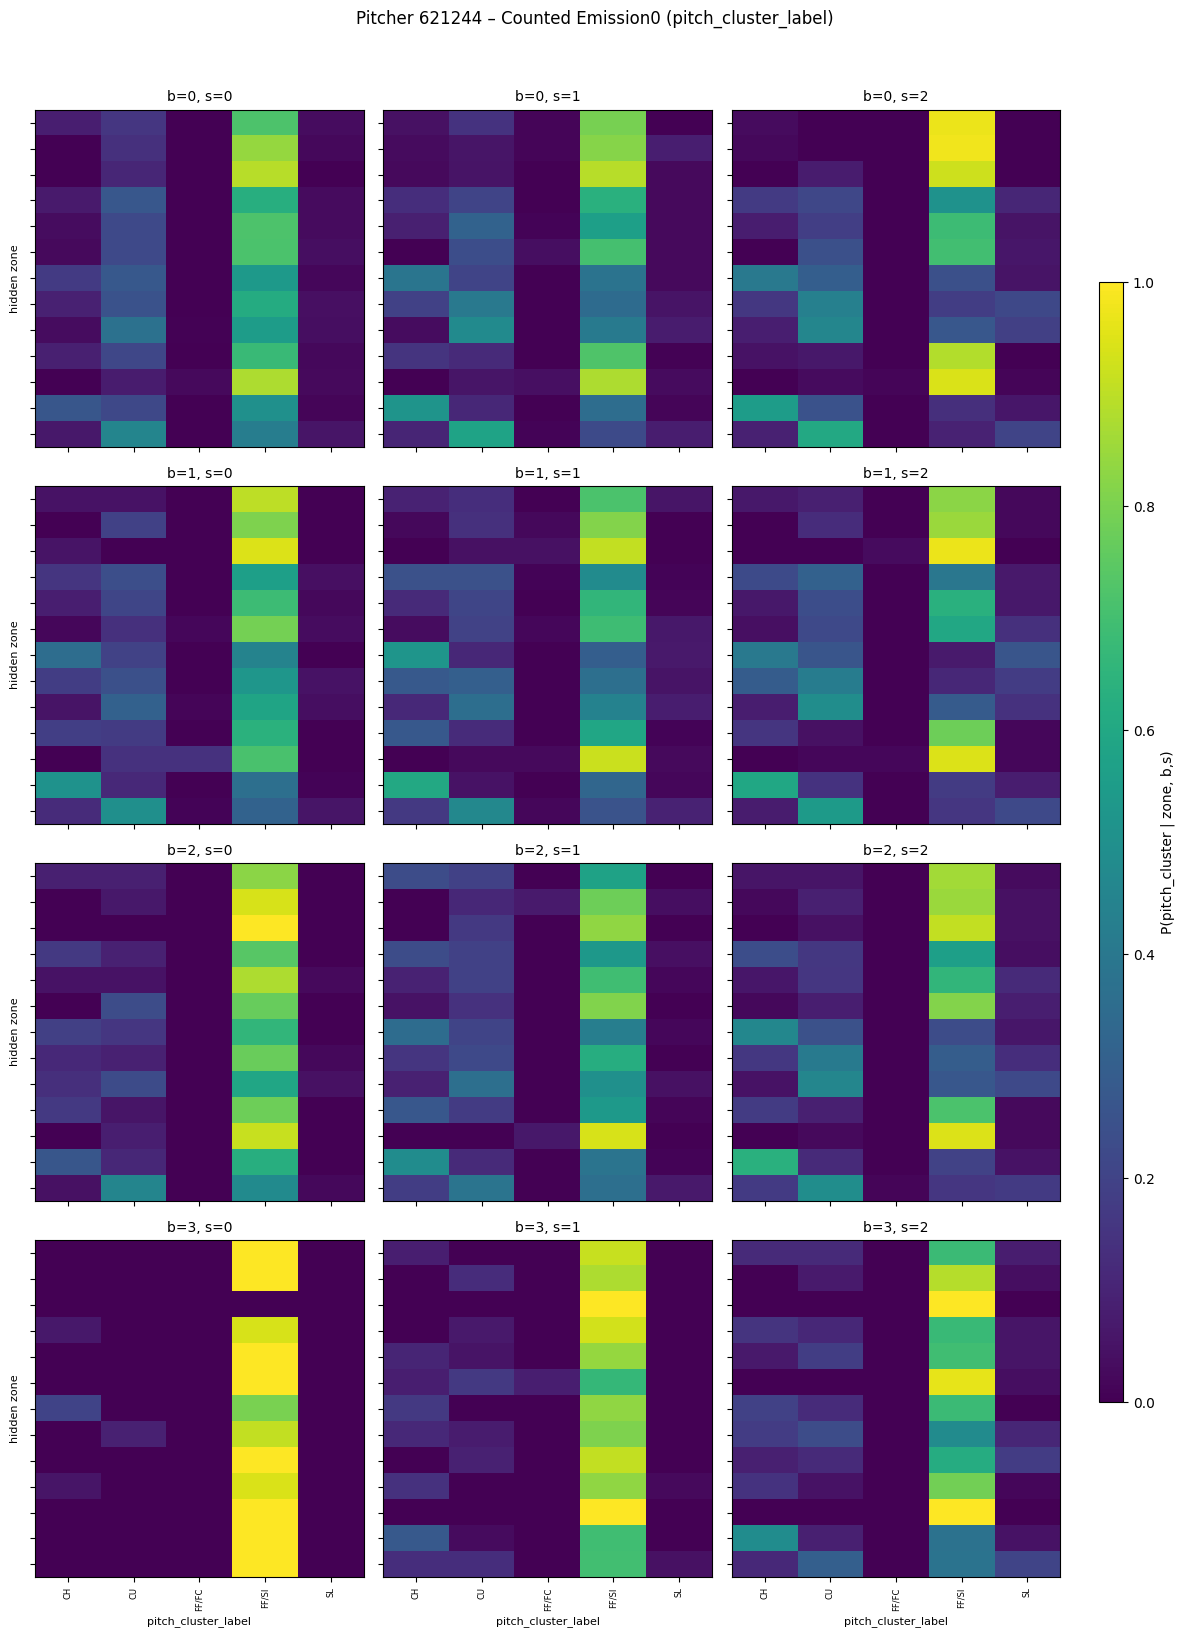

/tmp/ipykernel_697038/2191143804.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


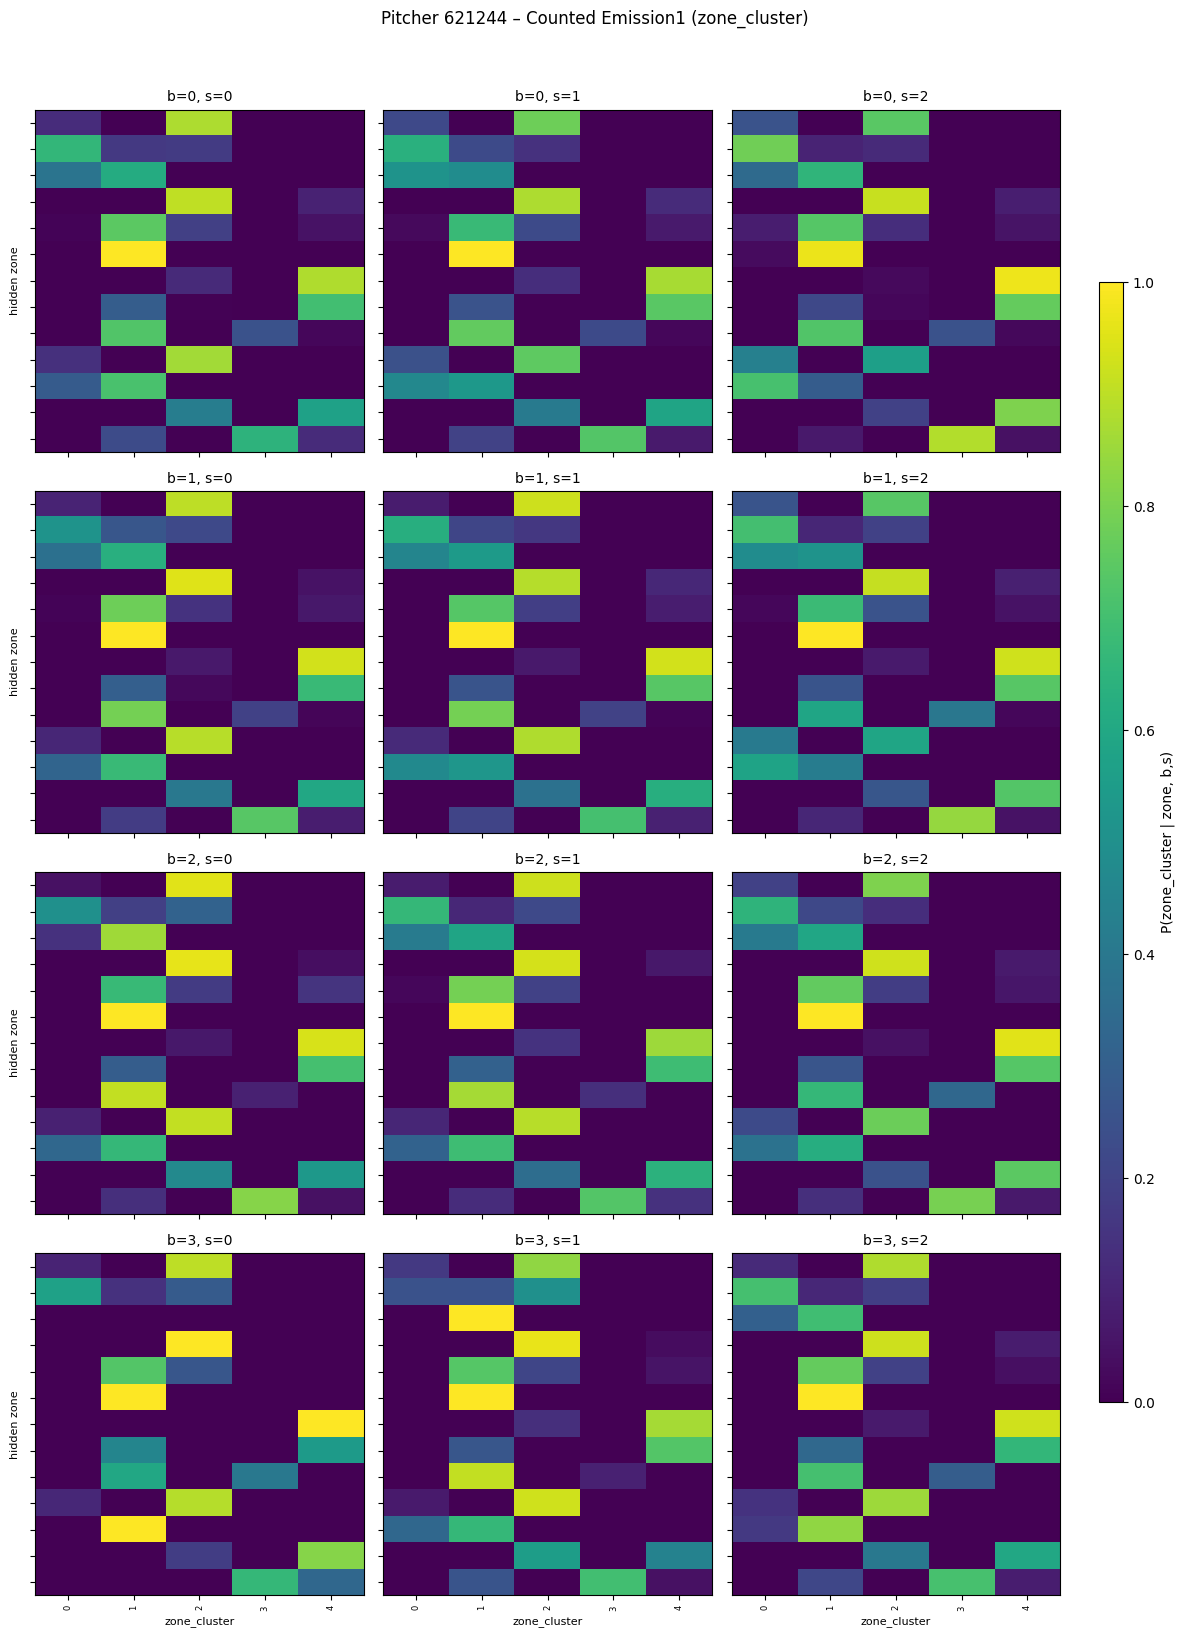


=== Pitcher 656302 の集計 ===


/tmp/ipykernel_697038/2191143804.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


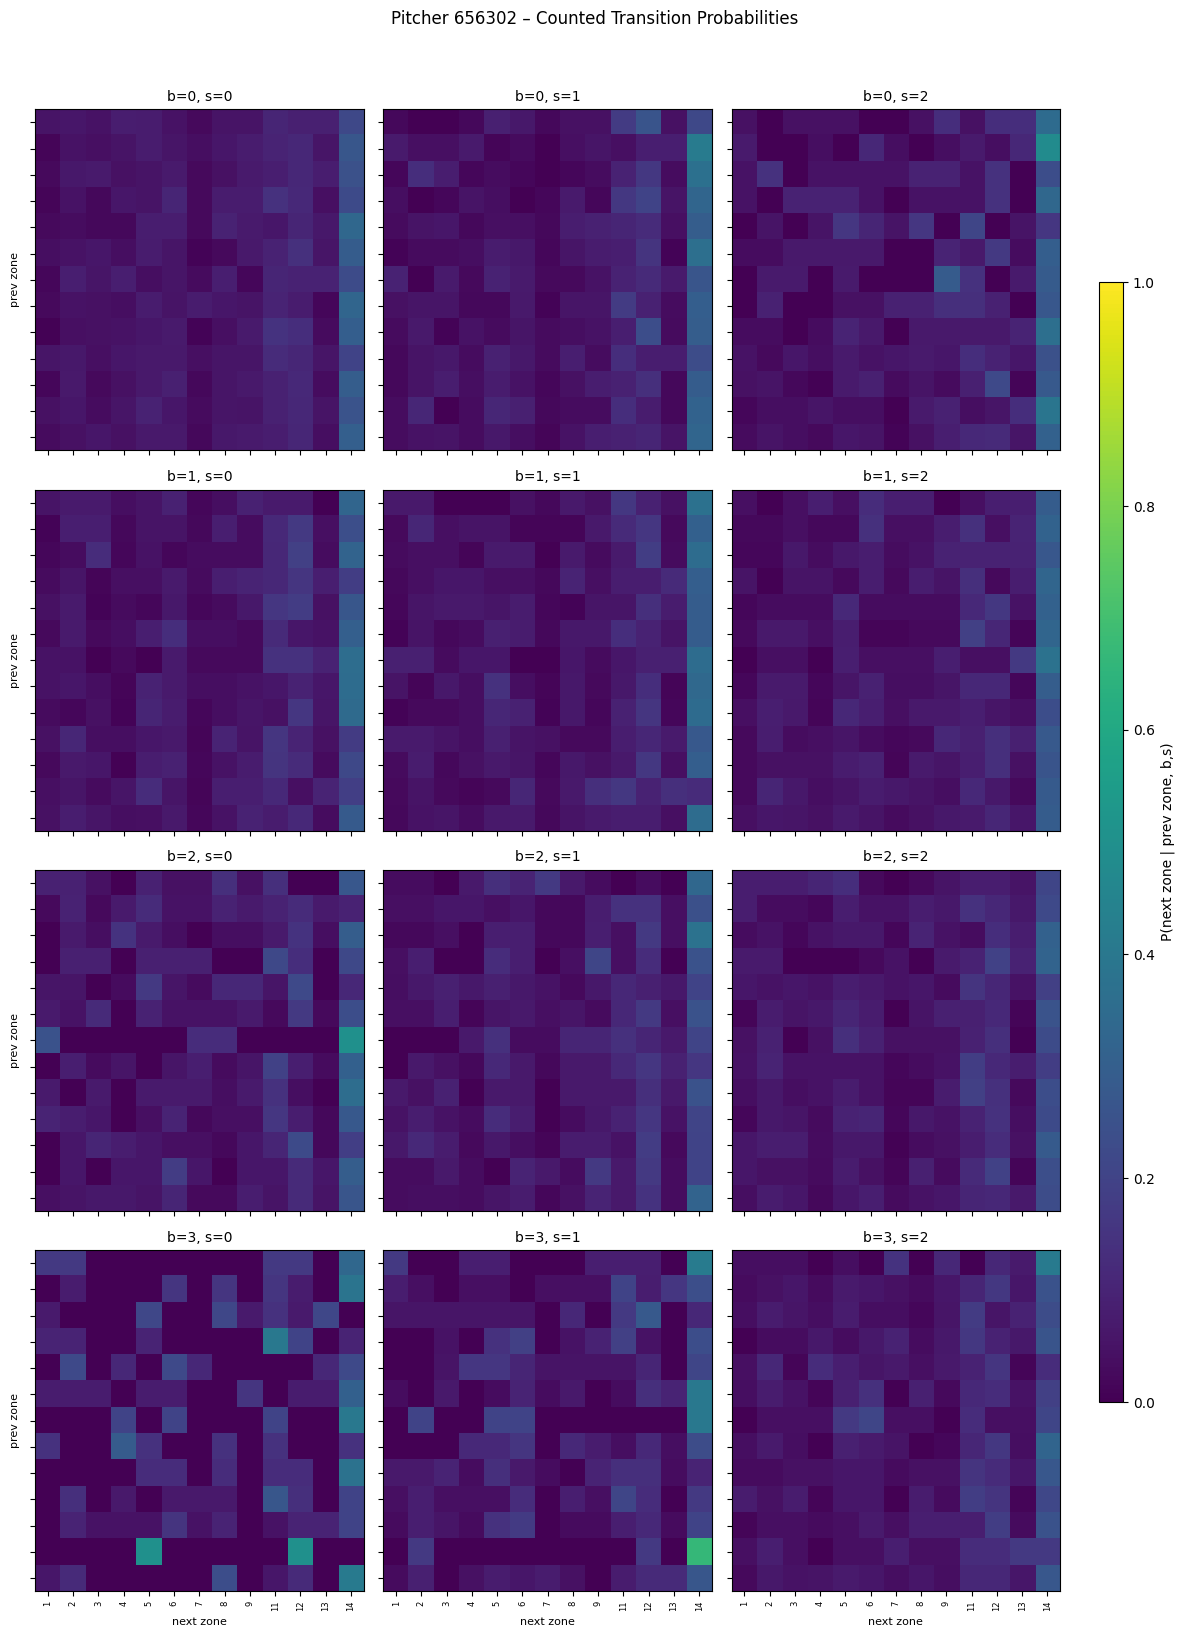

/tmp/ipykernel_697038/2191143804.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


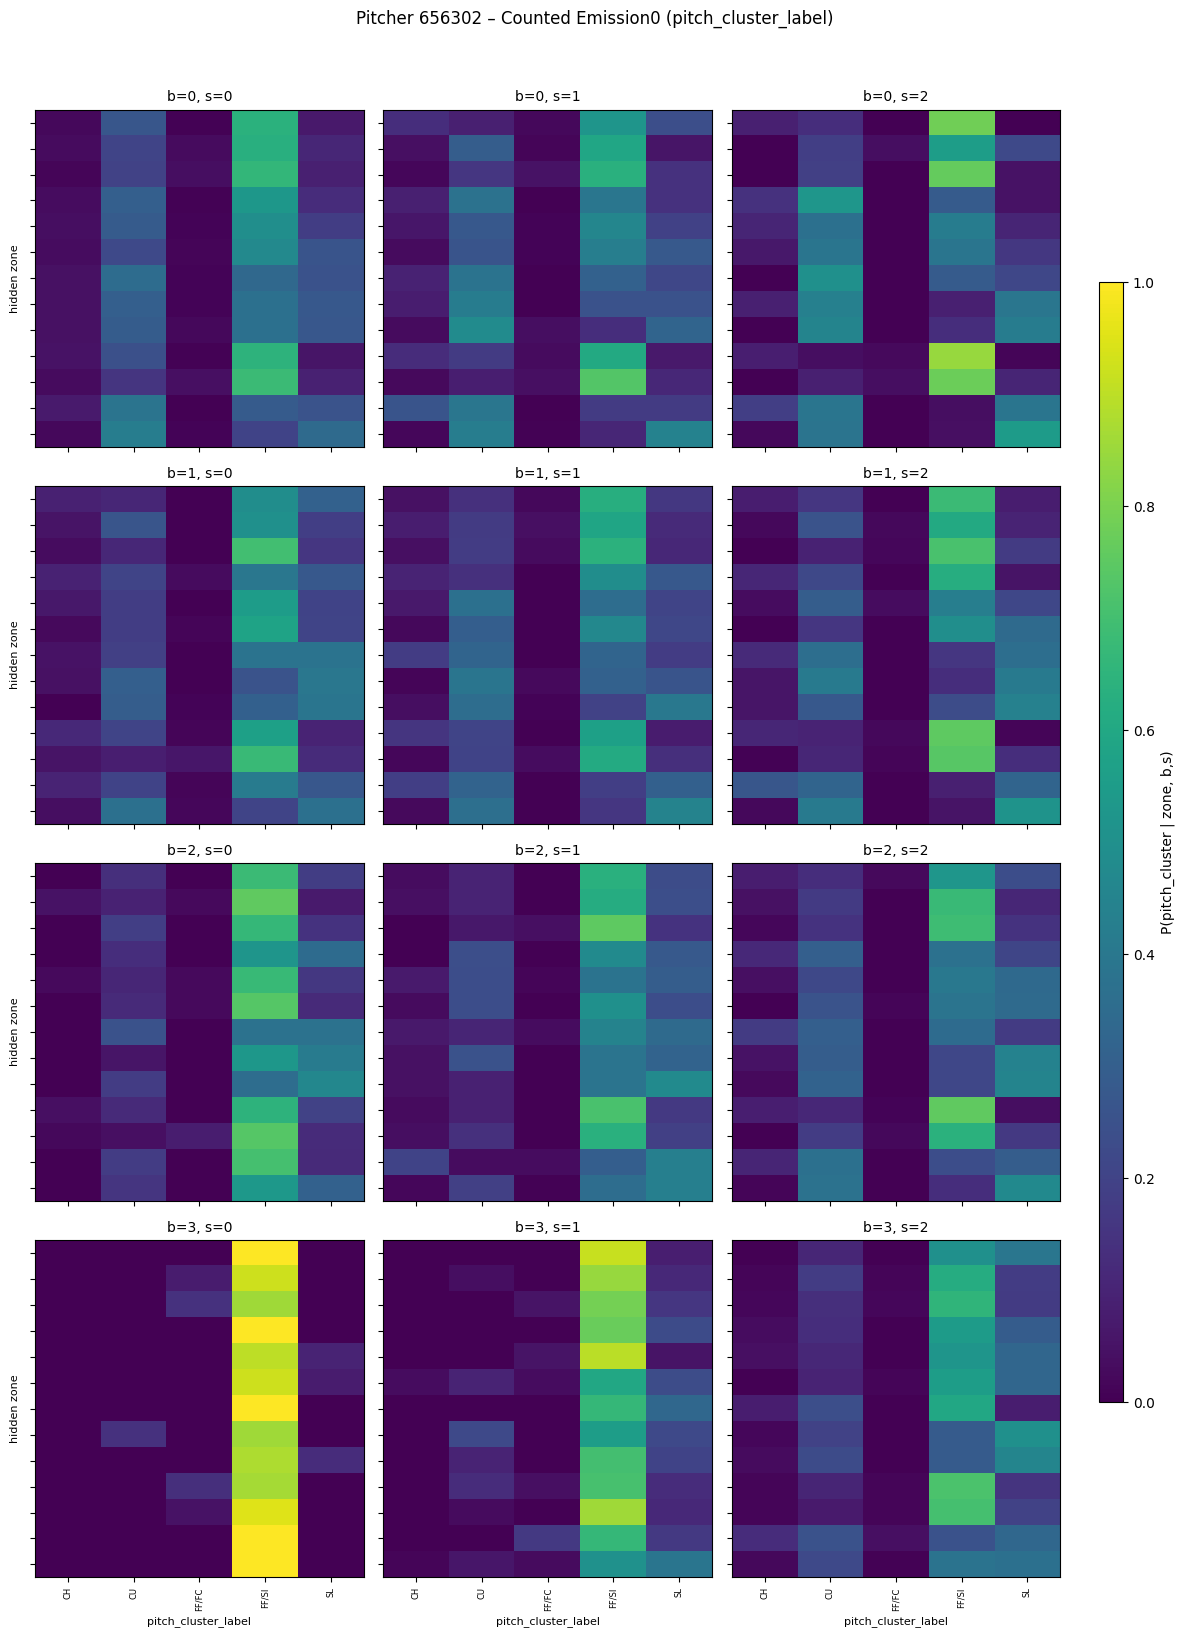

/tmp/ipykernel_697038/2191143804.py:241: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.0])


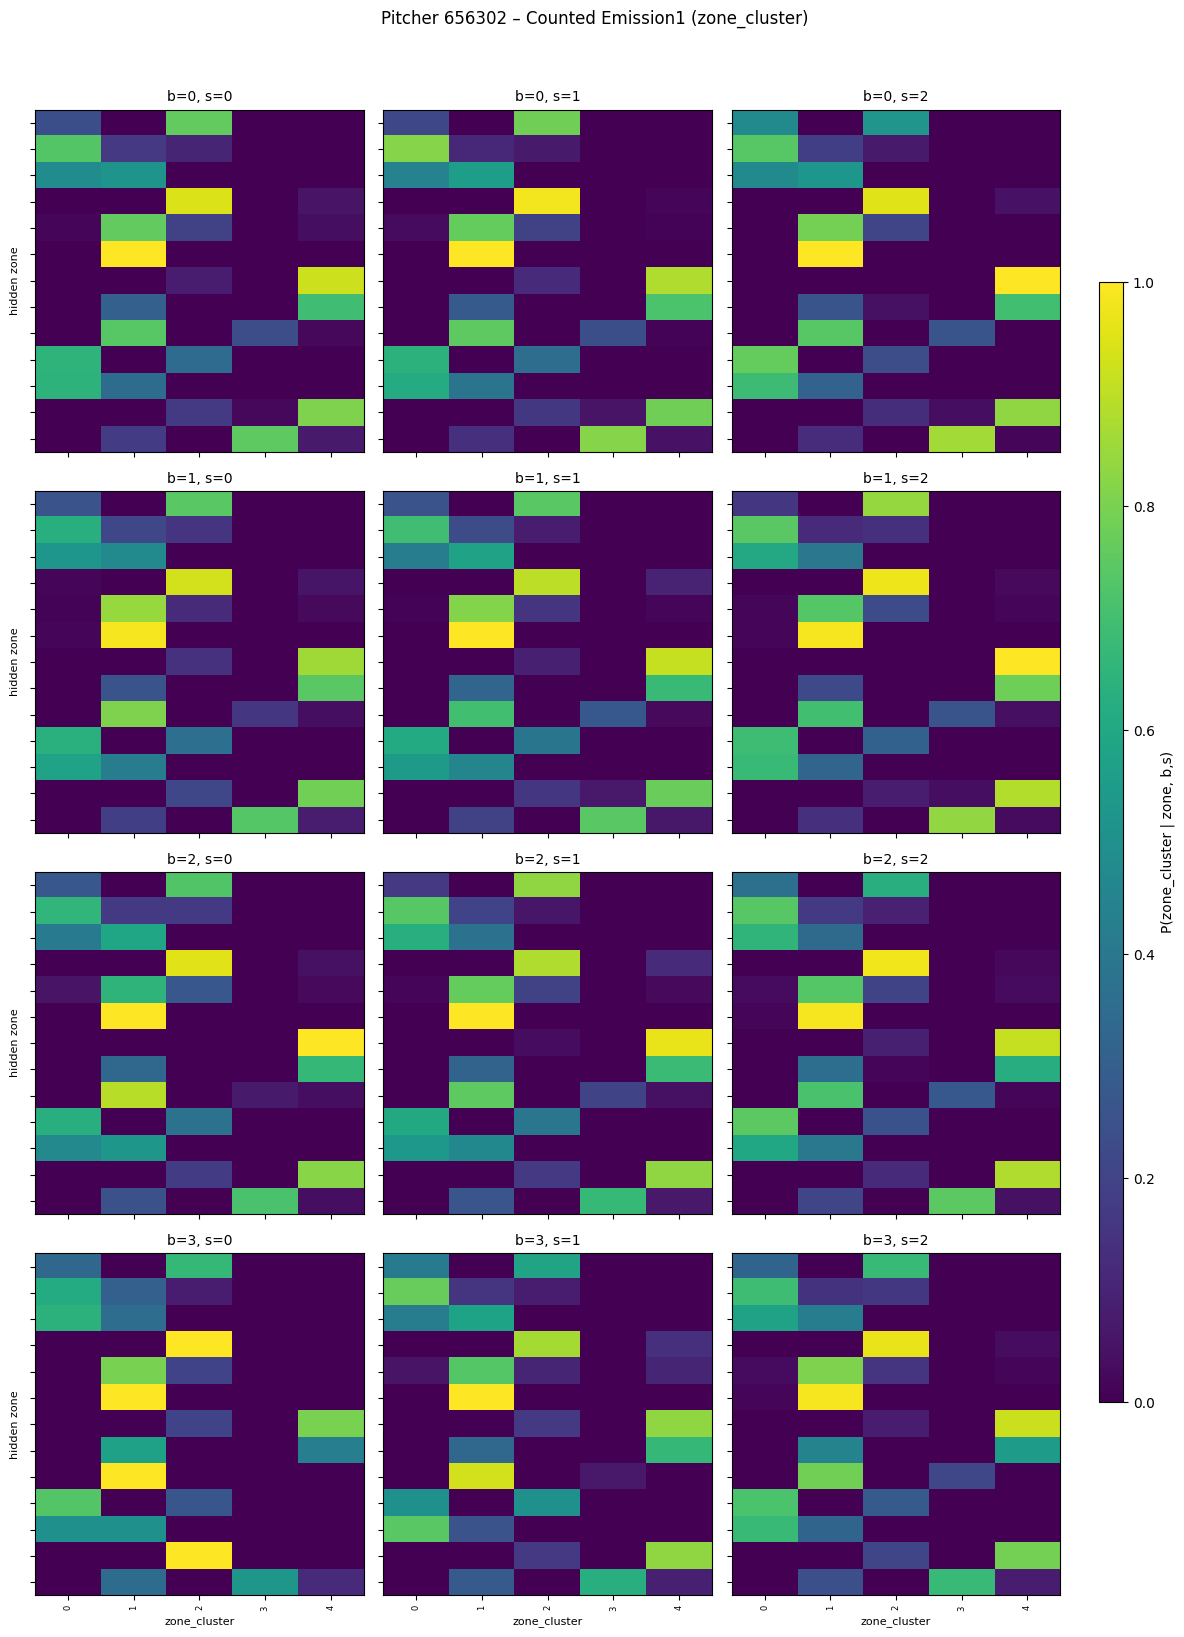

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# -----------------------------------------------------------------------------
# 前提：同じディレクトリに 'df_clean_zone_cluster.csv' があるものとする
# -----------------------------------------------------------------------------
df_all = pd.read_csv('df_clean_zone_cluster.csv')

# -----------------------------------------------------------------------------
# 1) パラメータ定義
# -----------------------------------------------------------------------------
pitch_list = ["543037", "554430", "605400", "621244", "656302"]
covs       = [(b, s) for b in range(4) for s in range(3)]

# 隠れ状態 (zone) のクラス数とマッピングを準備（数値型と仮定）
all_zones = pd.Series(df_all['zone'].dropna().unique()).astype(int).sort_values().tolist()
K = len(all_zones)
zone_to_idx = {z: i for i, z in enumerate(all_zones)}
idx_to_zone = {i: z for i, z in enumerate(all_zones)}

# 出力クラス (pitch_cluster_label, zone_cluster) のクラス一覧を取得（文字列のまま）
all_pcl = pd.Series(df_all['pitch_cluster_label'].dropna().unique()).astype(str).sort_values().tolist()
all_zcl = pd.Series(df_all['zone_cluster'].dropna().unique()).astype(str).sort_values().tolist()
C_pcl = len(all_pcl)
C_zcl = len(all_zcl)
pcl_to_idx = {c: i for i, c in enumerate(all_pcl)}
idx_to_pcl = {i: c for i, c in enumerate(all_pcl)}
zcl_to_idx = {c: i for i, c in enumerate(all_zcl)}
idx_to_zcl = {i: c for i, c in enumerate(all_zcl)}

# -----------------------------------------------------------------------------
# 2) 投手ごとに「遷移確率」と「Emission 確率」を数え上げ＆可視化
# -----------------------------------------------------------------------------
for pid in pitch_list:
    print(f"\n=== Pitcher {pid} の集計 ===")

    # (1) 当該投手データ抽出＆ゲームごと時系列ソート
    df_p = df_all[df_all['pitcher'].astype(str) == pid].sort_values('game_pk').reset_index(drop=True)
    if df_p.empty:
        print(f" データが見つかりません（スキップ）")
        continue

    # -----------------------------------------------------------------------------
    # (A) 遷移確率の数え上げ：records_trans に (b,s, prev_z, next_z) を格納
    # -----------------------------------------------------------------------------
    records_trans = []
    for _, grp in df_p.groupby('game_pk'):
        bs_vals   = grp[['balls','strikes']].values
        zone_vals = grp['zone'].values
        if len(zone_vals) < 2:
            continue
        for i in range(len(zone_vals) - 1):
            b, s      = bs_vals[i]
            prev_z    = zone_to_idx[int(zone_vals[i])]
            next_z    = zone_to_idx[int(zone_vals[i+1])]
            records_trans.append((b, s, prev_z, next_z))

    if not records_trans:
        print(" 遷移サンプルがありません（スキップ）")
        continue

    df_trans = pd.DataFrame(records_trans, columns=['balls','strikes','prev_z','next_z'])

    # -----------------------------------------------------------------------------
    # (B) Emission0 (pitch_cluster_label) の数え上げ：records_emit_p に (b,s, zone, pcl) を格納
    # -----------------------------------------------------------------------------
    records_emit_p = []
    for _, grp in df_p.groupby('game_pk'):
        bs_vals   = grp[['balls','strikes']].values
        zone_vals = grp['zone'].values
        pcl_vals  = grp['pitch_cluster_label'].astype(str).values
        for i in range(len(zone_vals)):
            b, s = bs_vals[i]
            z    = zone_to_idx[int(zone_vals[i])]
            pcl  = pcl_to_idx[pcl_vals[i]]   # 文字列キーのまま lookup
            records_emit_p.append((b, s, z, pcl))

    df_emit_p = pd.DataFrame(records_emit_p, columns=['balls','strikes','zone','pcl'])

    # -----------------------------------------------------------------------------
    # (C) Emission1 (zone_cluster) の数え上げ：records_emit_z に (b,s, zone, zcl) を格納
    # -----------------------------------------------------------------------------
    records_emit_z = []
    for _, grp in df_p.groupby('game_pk'):
        bs_vals   = grp[['balls','strikes']].values
        zone_vals = grp['zone'].values
        zcl_vals  = grp['zone_cluster'].astype(str).values
        for i in range(len(zone_vals)):
            b, s = bs_vals[i]
            z    = zone_to_idx[int(zone_vals[i])]
            zcl  = zcl_to_idx[zcl_vals[i]]   # 文字列キーのまま lookup
            records_emit_z.append((b, s, z, zcl))

    df_emit_z = pd.DataFrame(records_emit_z, columns=['balls','strikes','zone','zcl'])

    # -----------------------------------------------------------------------------
    # (D) (balls, strikes) ごとに「遷移確率行列」「Emission0 分布」「Emission1 分布」を正規化して辞書化
    # -----------------------------------------------------------------------------
    trans_prob_dict    = {}
    emit_prob_p_dict   = {}
    emit_prob_z_dict   = {}

    for b, s in covs:
        # (D-1) 遷移
        tmp_t = df_trans[(df_trans['balls']==b) & (df_trans['strikes']==s)]
        if not tmp_t.empty:
            cm_t = tmp_t.pivot_table(index='prev_z', columns='next_z', aggfunc='size', fill_value=0)
            cm_t = cm_t.reindex(index=range(K), columns=range(K), fill_value=0)
            row_sums = cm_t.sum(axis=1).values.reshape(-1,1)
            trans_prob = cm_t.div(row_sums, axis=0).fillna(0)
        else:
            trans_prob = pd.DataFrame(np.zeros((K, K)), index=range(K), columns=range(K))
        trans_prob_dict[(b,s)] = trans_prob

        # (D-2) Emission0: pitch_cluster_label
        tmp_p = df_emit_p[(df_emit_p['balls']==b) & (df_emit_p['strikes']==s)]
        if not tmp_p.empty:
            cm_p = tmp_p.pivot_table(index='zone', columns='pcl', aggfunc='size', fill_value=0)
            cm_p = cm_p.reindex(index=range(K), columns=range(C_pcl), fill_value=0)
            row_sums_p = cm_p.sum(axis=1).values.reshape(-1,1)
            emit_prob_p = cm_p.div(row_sums_p, axis=0).fillna(0)
        else:
            emit_prob_p = pd.DataFrame(np.zeros((K, C_pcl)), index=range(K), columns=range(C_pcl))
        emit_prob_p_dict[(b,s)] = emit_prob_p

        # (D-3) Emission1: zone_cluster
        tmp_z = df_emit_z[(df_emit_z['balls']==b) & (df_emit_z['strikes']==s)]
        if not tmp_z.empty:
            cm_z = tmp_z.pivot_table(index='zone', columns='zcl', aggfunc='size', fill_value=0)
            cm_z = cm_z.reindex(index=range(K), columns=range(C_zcl), fill_value=0)
            row_sums_z = cm_z.sum(axis=1).values.reshape(-1,1)
            emit_prob_z = cm_z.div(row_sums_z, axis=0).fillna(0)
        else:
            emit_prob_z = pd.DataFrame(np.zeros((K, C_zcl)), index=range(K), columns=range(C_zcl))
        emit_prob_z_dict[(b,s)] = emit_prob_z

    # -----------------------------------------------------------------------------
    # (E) 遷移確率をプロット：4×3 グリッド
    # -----------------------------------------------------------------------------
    n_cov  = len(covs)
    n_cols = 3
    n_rows = ceil(n_cov / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)
    fig.suptitle(f"Pitcher {pid} – Counted Transition Probabilities", y=1.02)

    axes = axes.flatten()
    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        mat = trans_prob_dict[(b, s)].values  # shape = (K, K)
        im = ax.imshow(mat, vmin=0.0, vmax=1.0, aspect='auto', cmap='viridis')
        ax.set_title(f"b={b}, s={s}", fontsize=10)
        ax.set_xticks(np.arange(K))
        ax.set_yticks(np.arange(K))
        ax.set_xticklabels([idx_to_zone[i] for i in range(K)], rotation=90, fontsize=6)
        ax.set_yticklabels([idx_to_zone[i] for i in range(K)],           fontsize=6)
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("next zone", fontsize=8)
        else:
            ax.set_xticklabels([])
        if idx % n_cols == 0:
            ax.set_ylabel("prev zone", fontsize=8)
        else:
            ax.set_yticklabels([])

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(next zone | prev zone, b,s)")
    plt.tight_layout(rect=[0, 0, 0.9, 1.0])
    plt.show()

    # -----------------------------------------------------------------------------
    # (F) Emission0 (pitch_cluster_label) をプロット：4×3 グリッド
    #     行: hidden zone (0..K-1), 列: pitch_cluster_label クラス
    # -----------------------------------------------------------------------------
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)
    fig.suptitle(f"Pitcher {pid} – Counted Emission0 (pitch_cluster_label)", y=1.02)

    axes = axes.flatten()
    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        mat_p = emit_prob_p_dict[(b, s)].values  # shape = (K, C_pcl)
        im = ax.imshow(mat_p, vmin=0.0, vmax=1.0, aspect='auto', cmap='viridis')
        ax.set_title(f"b={b}, s={s}", fontsize=10)
        ax.set_xticks(np.arange(C_pcl))
        ax.set_yticks(np.arange(K))
        ax.set_xticklabels([idx_to_pcl[i] for i in range(C_pcl)], rotation=90, fontsize=6)
        ax.set_yticklabels([idx_to_zone[i] for i in range(K)],           fontsize=6)
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("pitch_cluster_label", fontsize=8)
        else:
            ax.set_xticklabels([])
        if idx % n_cols == 0:
            ax.set_ylabel("hidden zone", fontsize=8)
        else:
            ax.set_yticklabels([])

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(pitch_cluster | zone, b,s)")
    plt.tight_layout(rect=[0, 0, 0.9, 1.0])
    plt.show()

    # -----------------------------------------------------------------------------
    # (G) Emission1 (zone_cluster) をプロット：4×3 グリッド
    #     行: hidden zone (0..K-1), 列: zone_cluster クラス
    # -----------------------------------------------------------------------------
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), sharex=True, sharey=True)
    fig.suptitle(f"Pitcher {pid} – Counted Emission1 (zone_cluster)", y=1.02)

    axes = axes.flatten()
    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        mat_z = emit_prob_z_dict[(b, s)].values  # shape = (K, C_zcl)
        im = ax.imshow(mat_z, vmin=0.0, vmax=1.0, aspect='auto', cmap='viridis')
        ax.set_title(f"b={b}, s={s}", fontsize=10)
        ax.set_xticks(np.arange(C_zcl))
        ax.set_yticks(np.arange(K))
        ax.set_xticklabels([idx_to_zcl[i] for i in range(C_zcl)], rotation=90, fontsize=6)
        ax.set_yticklabels([idx_to_zone[i] for i in range(K)],           fontsize=6)
        if idx // n_cols == n_rows - 1:
            ax.set_xlabel("zone_cluster", fontsize=8)
        else:
            ax.set_xticklabels([])
        if idx % n_cols == 0:
            ax.set_ylabel("hidden zone", fontsize=8)
        else:
            ax.set_yticklabels([])

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(zone_cluster | zone, b,s)")
    plt.tight_layout(rect=[0, 0, 0.9, 1.0])
    plt.show()
